<a href="https://colab.research.google.com/github/marcelohpos/PROJETO-ICD/blob/master/notebooks/Analise_Exploratoria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install calmap

In [2]:
!pip install calplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for calplot: filename=calplot-0.1.7.5-py3-none-any.whl size=8115 sha256=1871fbb47d615b40d0edf708c9a47a5e0901a194b27bf023ea89f2213374a3f5
  Stored in directory: /root/.cache/pip/wheels/f1/eb/af/79f8750a9f757aa0ccb6a0e217515abf3892f989345e98e50c
Successfully built calplot


In [3]:
# Importar bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
import numpy as np
import scipy.stats as st

In [4]:
# Carregar os dados
url1 = "https://raw.githubusercontent.com/marcelohpos/PROJETO-ICD/master/datasets/LA_daily_air_quality_clean.csv"
dados_clima = pd.read_csv(url1)

url2 = "https://raw.githubusercontent.com/marcelohpos/PROJETO-ICD/master/datasets/LA_daily_climate_clean.csv"
dados_temp = pd.read_csv(url2)

##**Panorama Geral**

In [5]:
# Garante que a coluna 'Data' está no formato datetime
dados_clima['Data'] = pd.to_datetime(dados_clima['Data'], errors='coerce')

# Remove linhas sem data válida
dados_validos = dados_clima.dropna(subset=['Data'])

# Extrai o ano e mostra os anos únicos e quantos são
anos_unicos = dados_validos['Data'].dt.year.unique()
quantos_anos = len(anos_unicos)

print(f"Anos presentes: {sorted(anos_unicos)}")
print(f"Quantidade de anos distintos: {quantos_anos}")

Anos presentes: [np.int32(2022), np.int32(2023), np.int32(2024)]
Quantidade de anos distintos: 3


In [6]:
dados_clima.describe()

Latitude     Longitude          PM10         PM2_5  \
count  12640.000000  12640.000000  12520.000000  12520.000000   
mean      -0.351840    -74.647240     20.669625     13.758530   
std       19.473623     12.946283     16.881122     11.665622   
min      -34.901100    -99.133200      0.300000      0.200000   
25%      -16.624925    -84.627075     11.400000      7.500000   
50%        9.455250    -75.557450     17.100000     11.200000   
75%       14.212950    -66.493175     24.700000     16.500000   
max       23.113600    -47.921800    292.400000    204.900000   

       Monóxido de Carbono (CO)  Dióxido de Nitrogênio (NO2)  \
count              12520.000000                 12520.000000   
mean                 414.904233                    22.484069   
std                  496.742344                    24.845234   
min                   58.000000                     0.000000   
25%                  181.000000                     6.700000   
50%                  263.000000                    15.100000   
75%                  444.000000                    30.900000   
max                 7635.000000                   324.400000   

       Dioxido de Enxofre(SO2)    Ozônio(O3)  
count             12520.000000  12520.000000  
mean                  8.930359     47.499201  
std                  13.674541     32.397686  
min                   0.000000      0.000000  
25%                   1.700000     26.000000  
50%                   4.100000     42.000000  
75%                  10.200000     62.000000  
max                 166.200000    332.000000

## **Pergunta Principal: Como a qualidade do ar em Brasília se compara com a das capitais de outros países, como Chile, Colômbia ou Argentina?**

### **1. Distribuição de gases e materiais particulados nas capitais latino-americanas**

##### **Versão A: Gráficos de Distribuição**

In [7]:
# Converter o DataFrame para formato longo (ideal para gráficos)
dados_longos = dados_clima.melt(
    id_vars=["Cidade"],
    value_vars=['PM10', 'PM2_5', 'Monóxido de Carbono (CO)', 'Dióxido de Nitrogênio (NO2)', 'Dioxido de Enxofre(SO2)', 'Ozônio(O3)'],
    var_name="Indicador",
    value_name="Valor"
)

✅ Indicadores prontos para histogramas: ['PM10', 'PM2_5', 'Monóxido de Carbono (CO)', 'Dióxido de Nitrogênio (NO2)', 'Dioxido de Enxofre(SO2)', 'Ozônio(O3)']


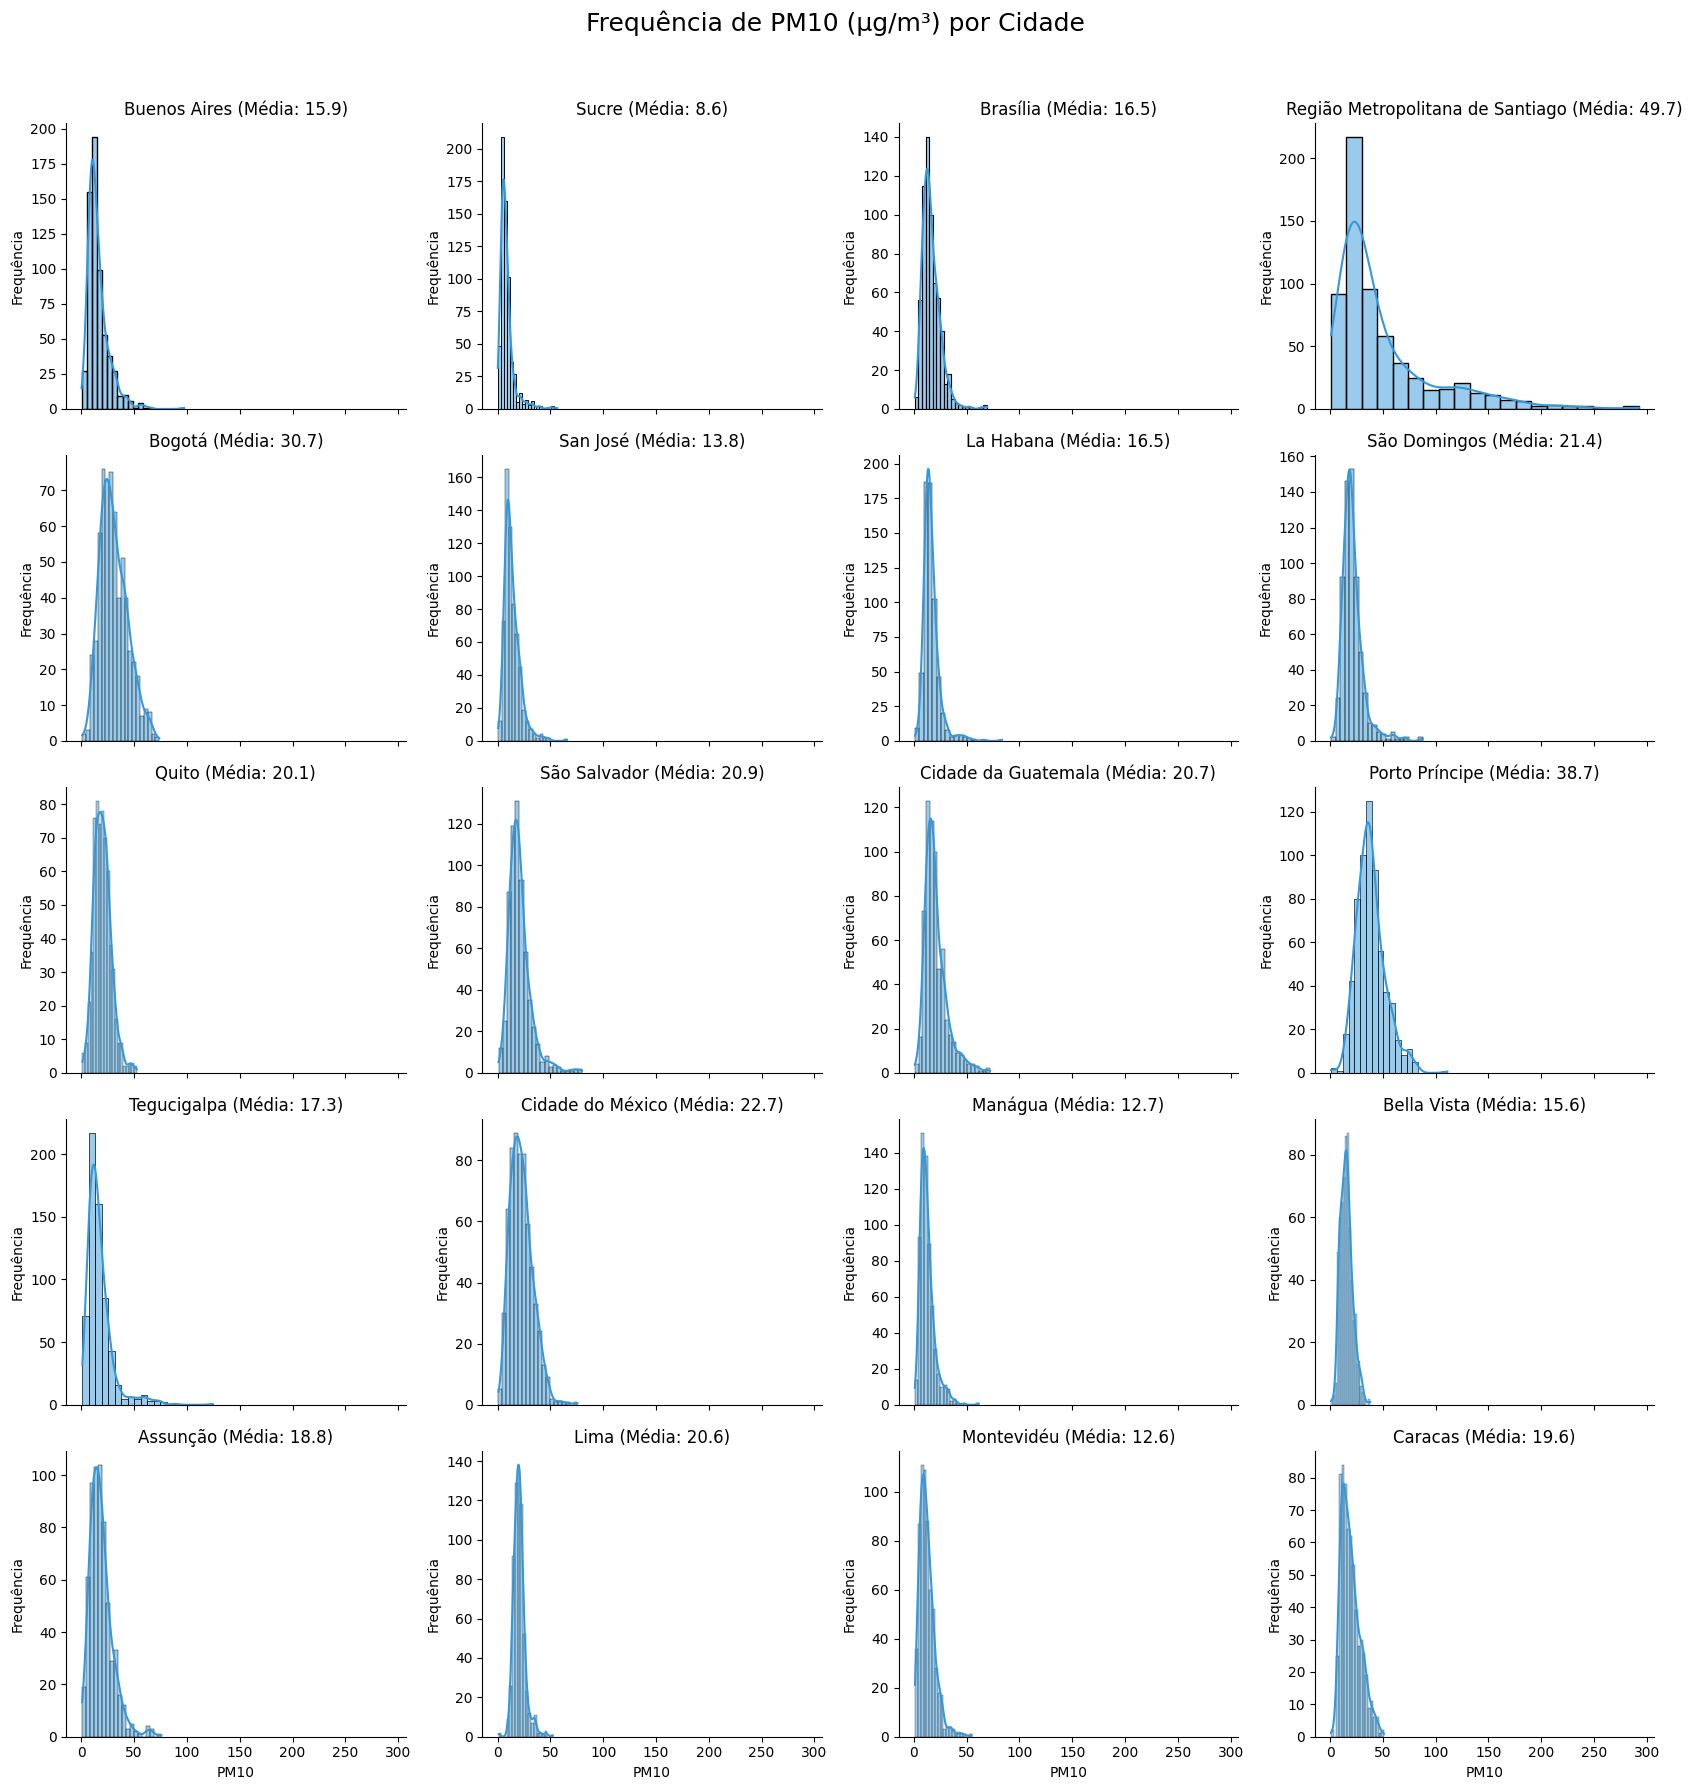

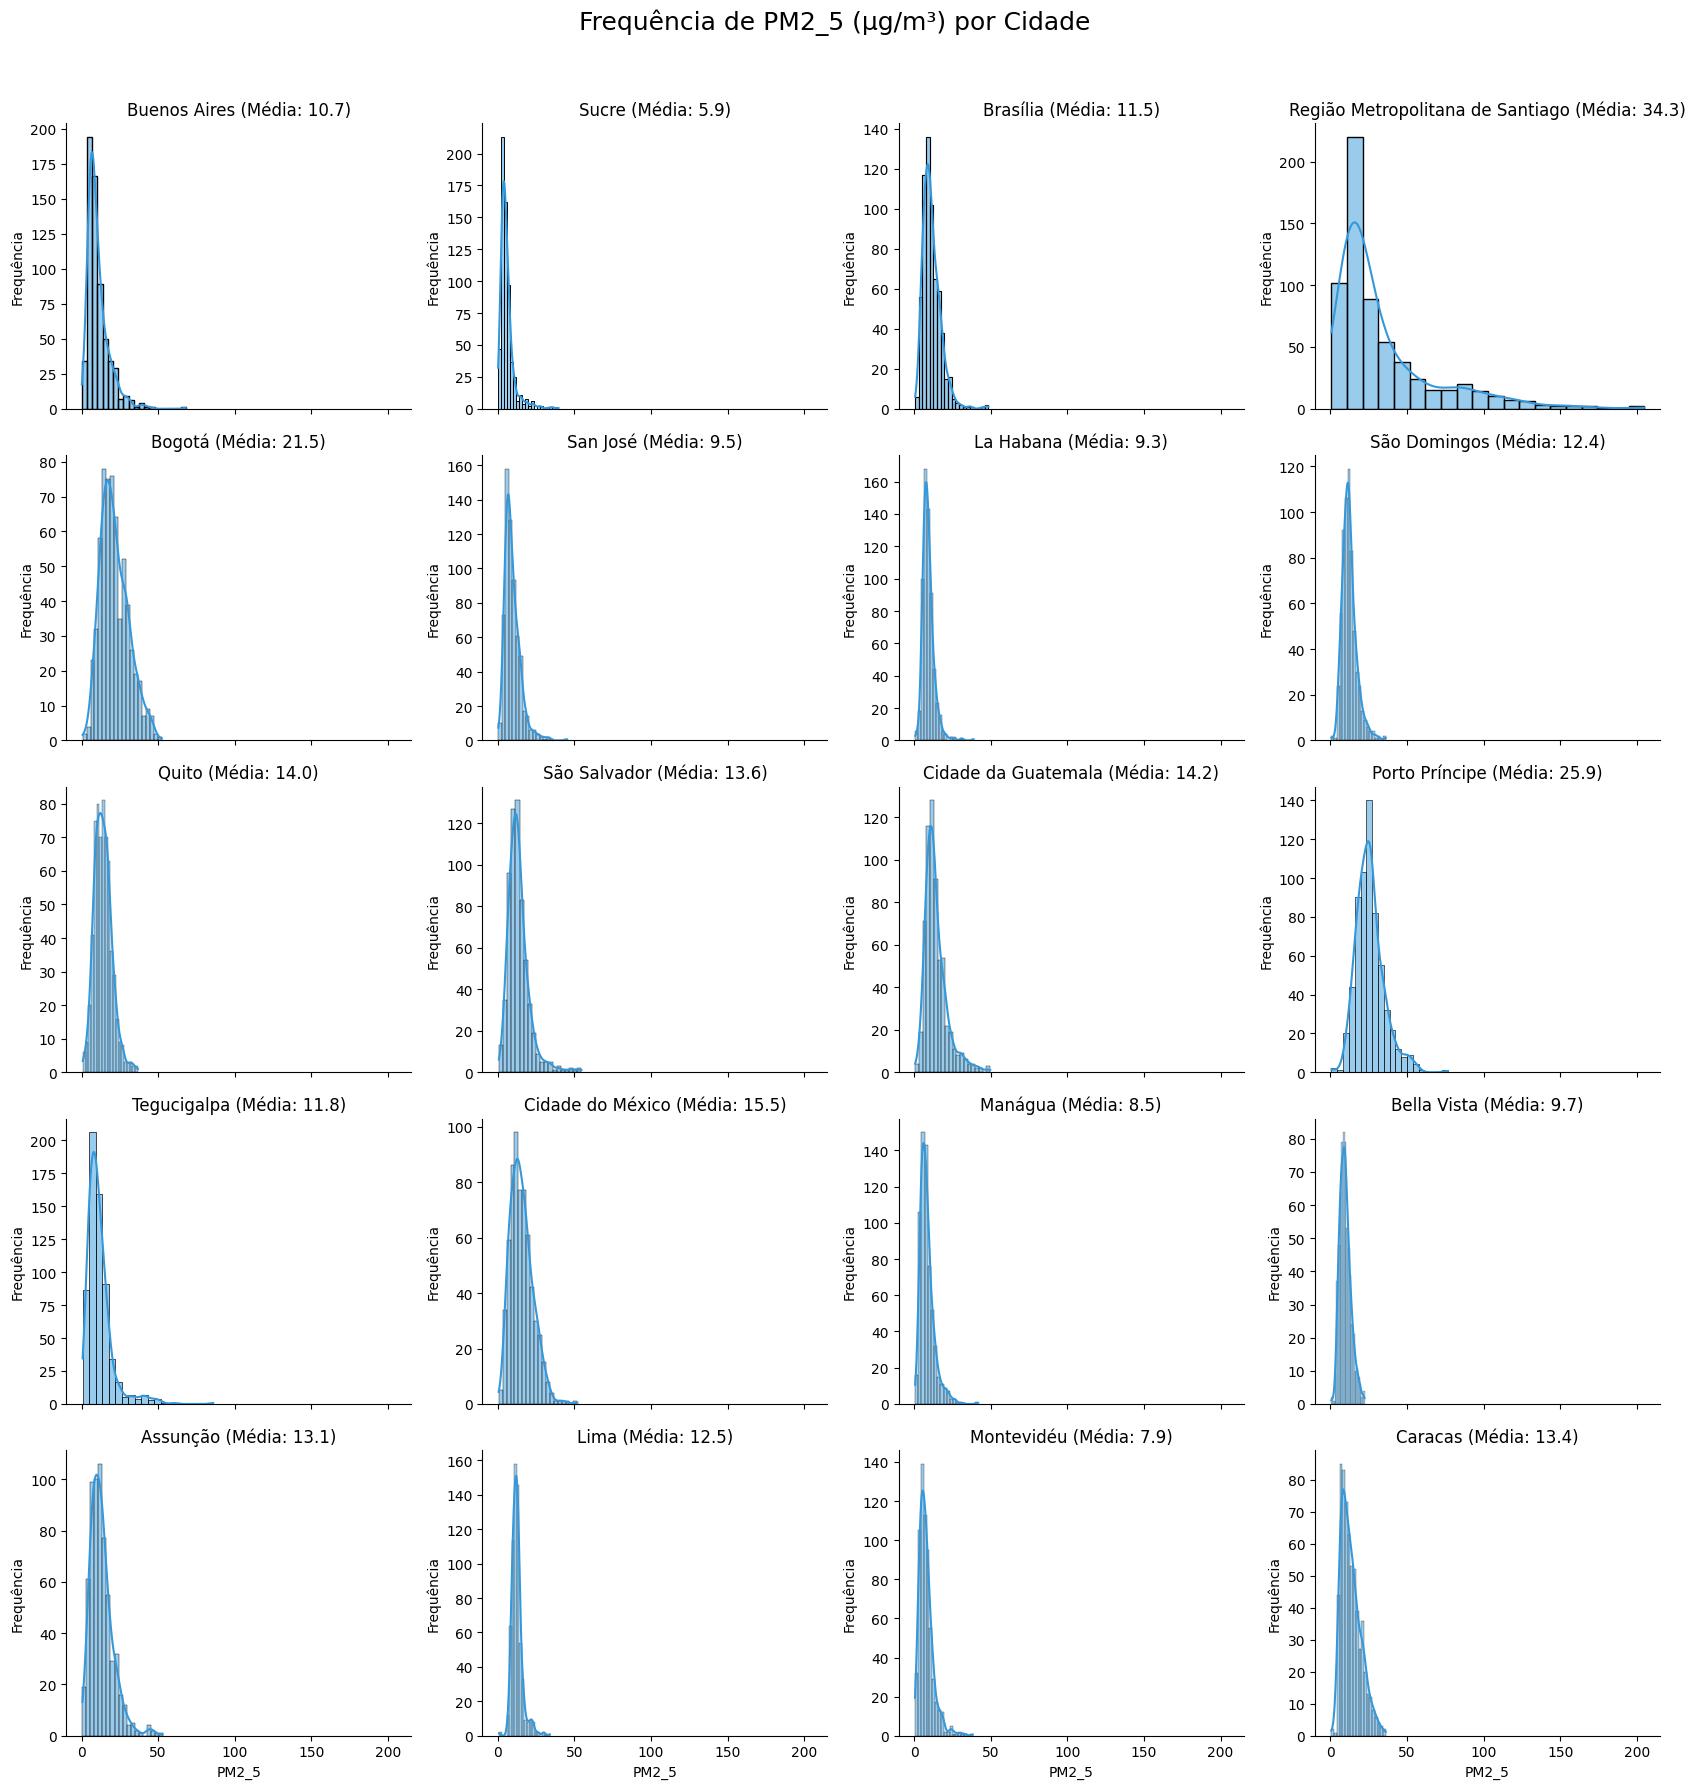

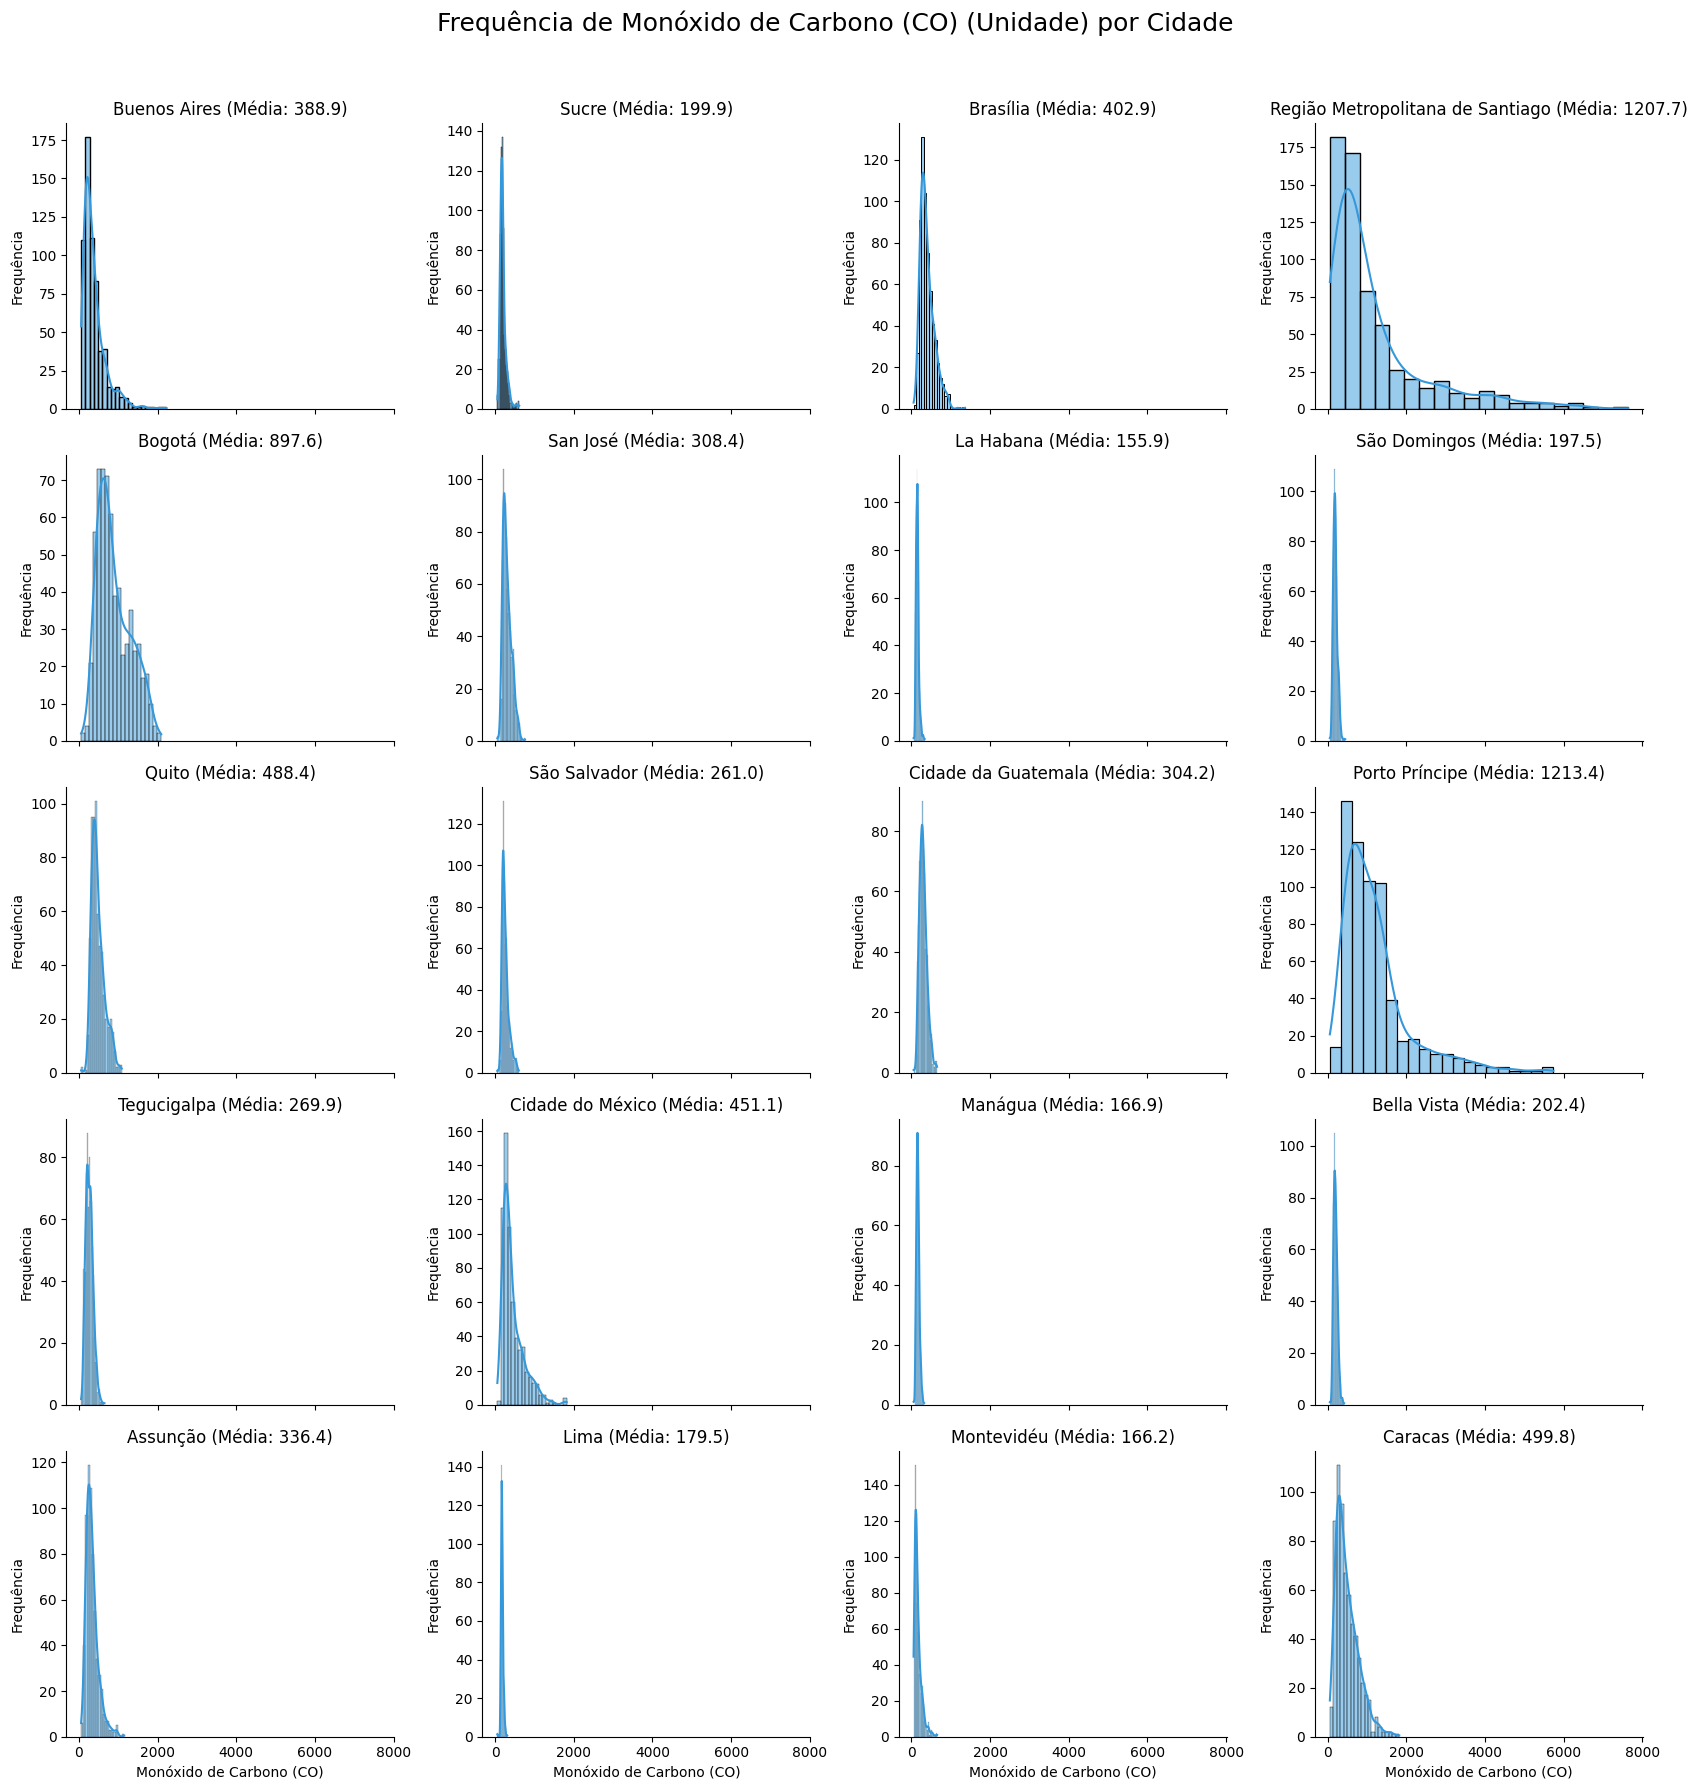

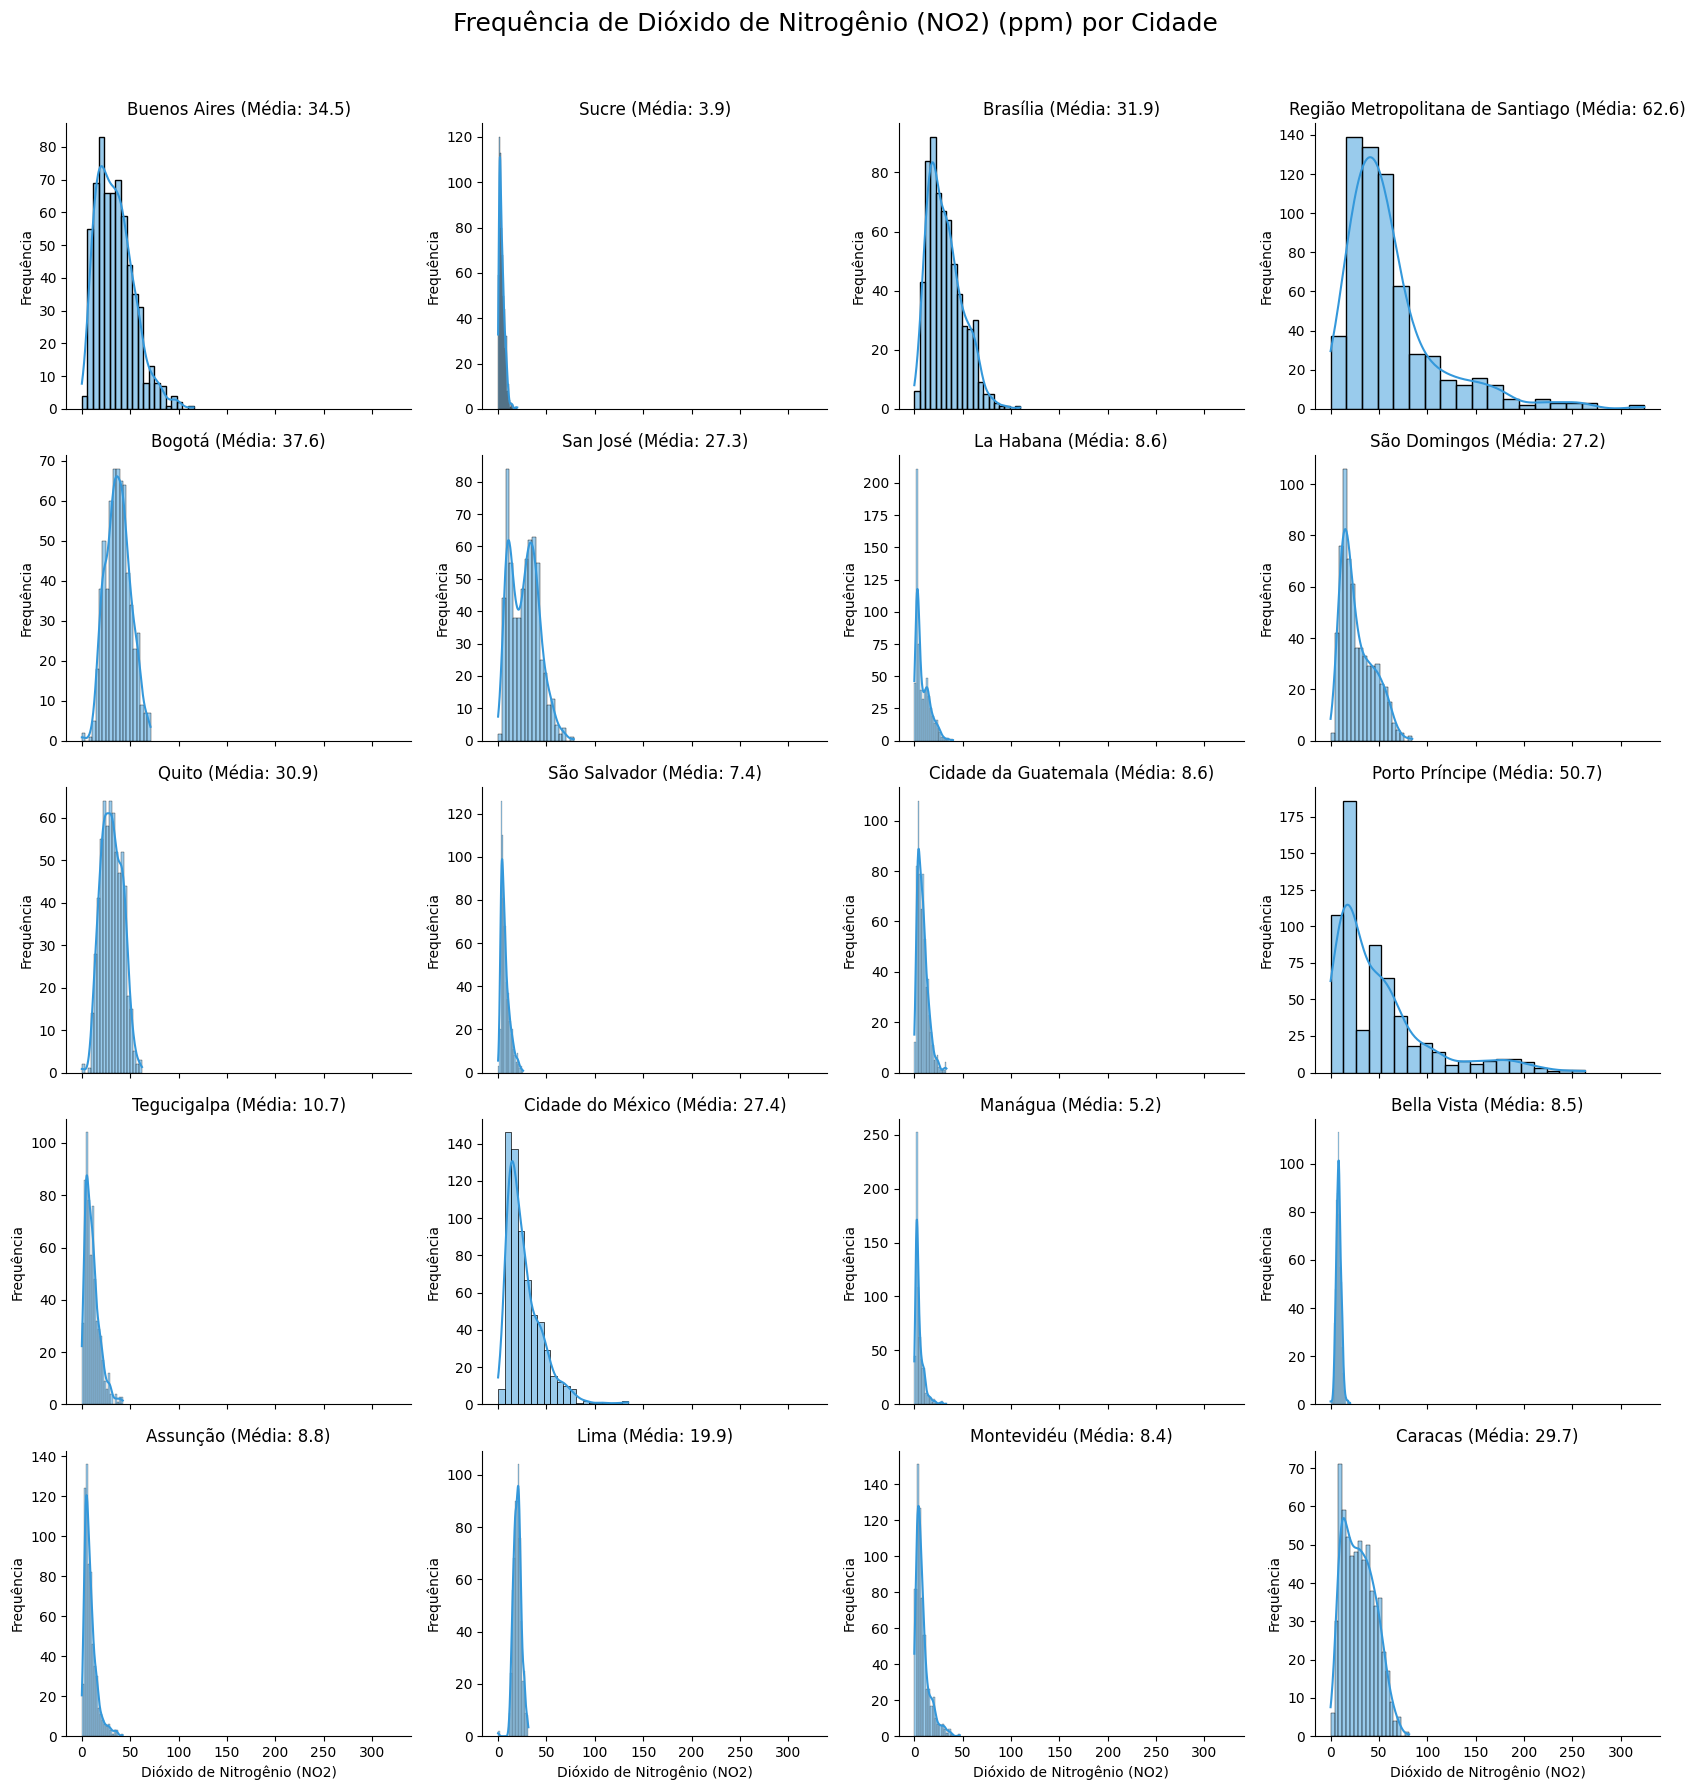

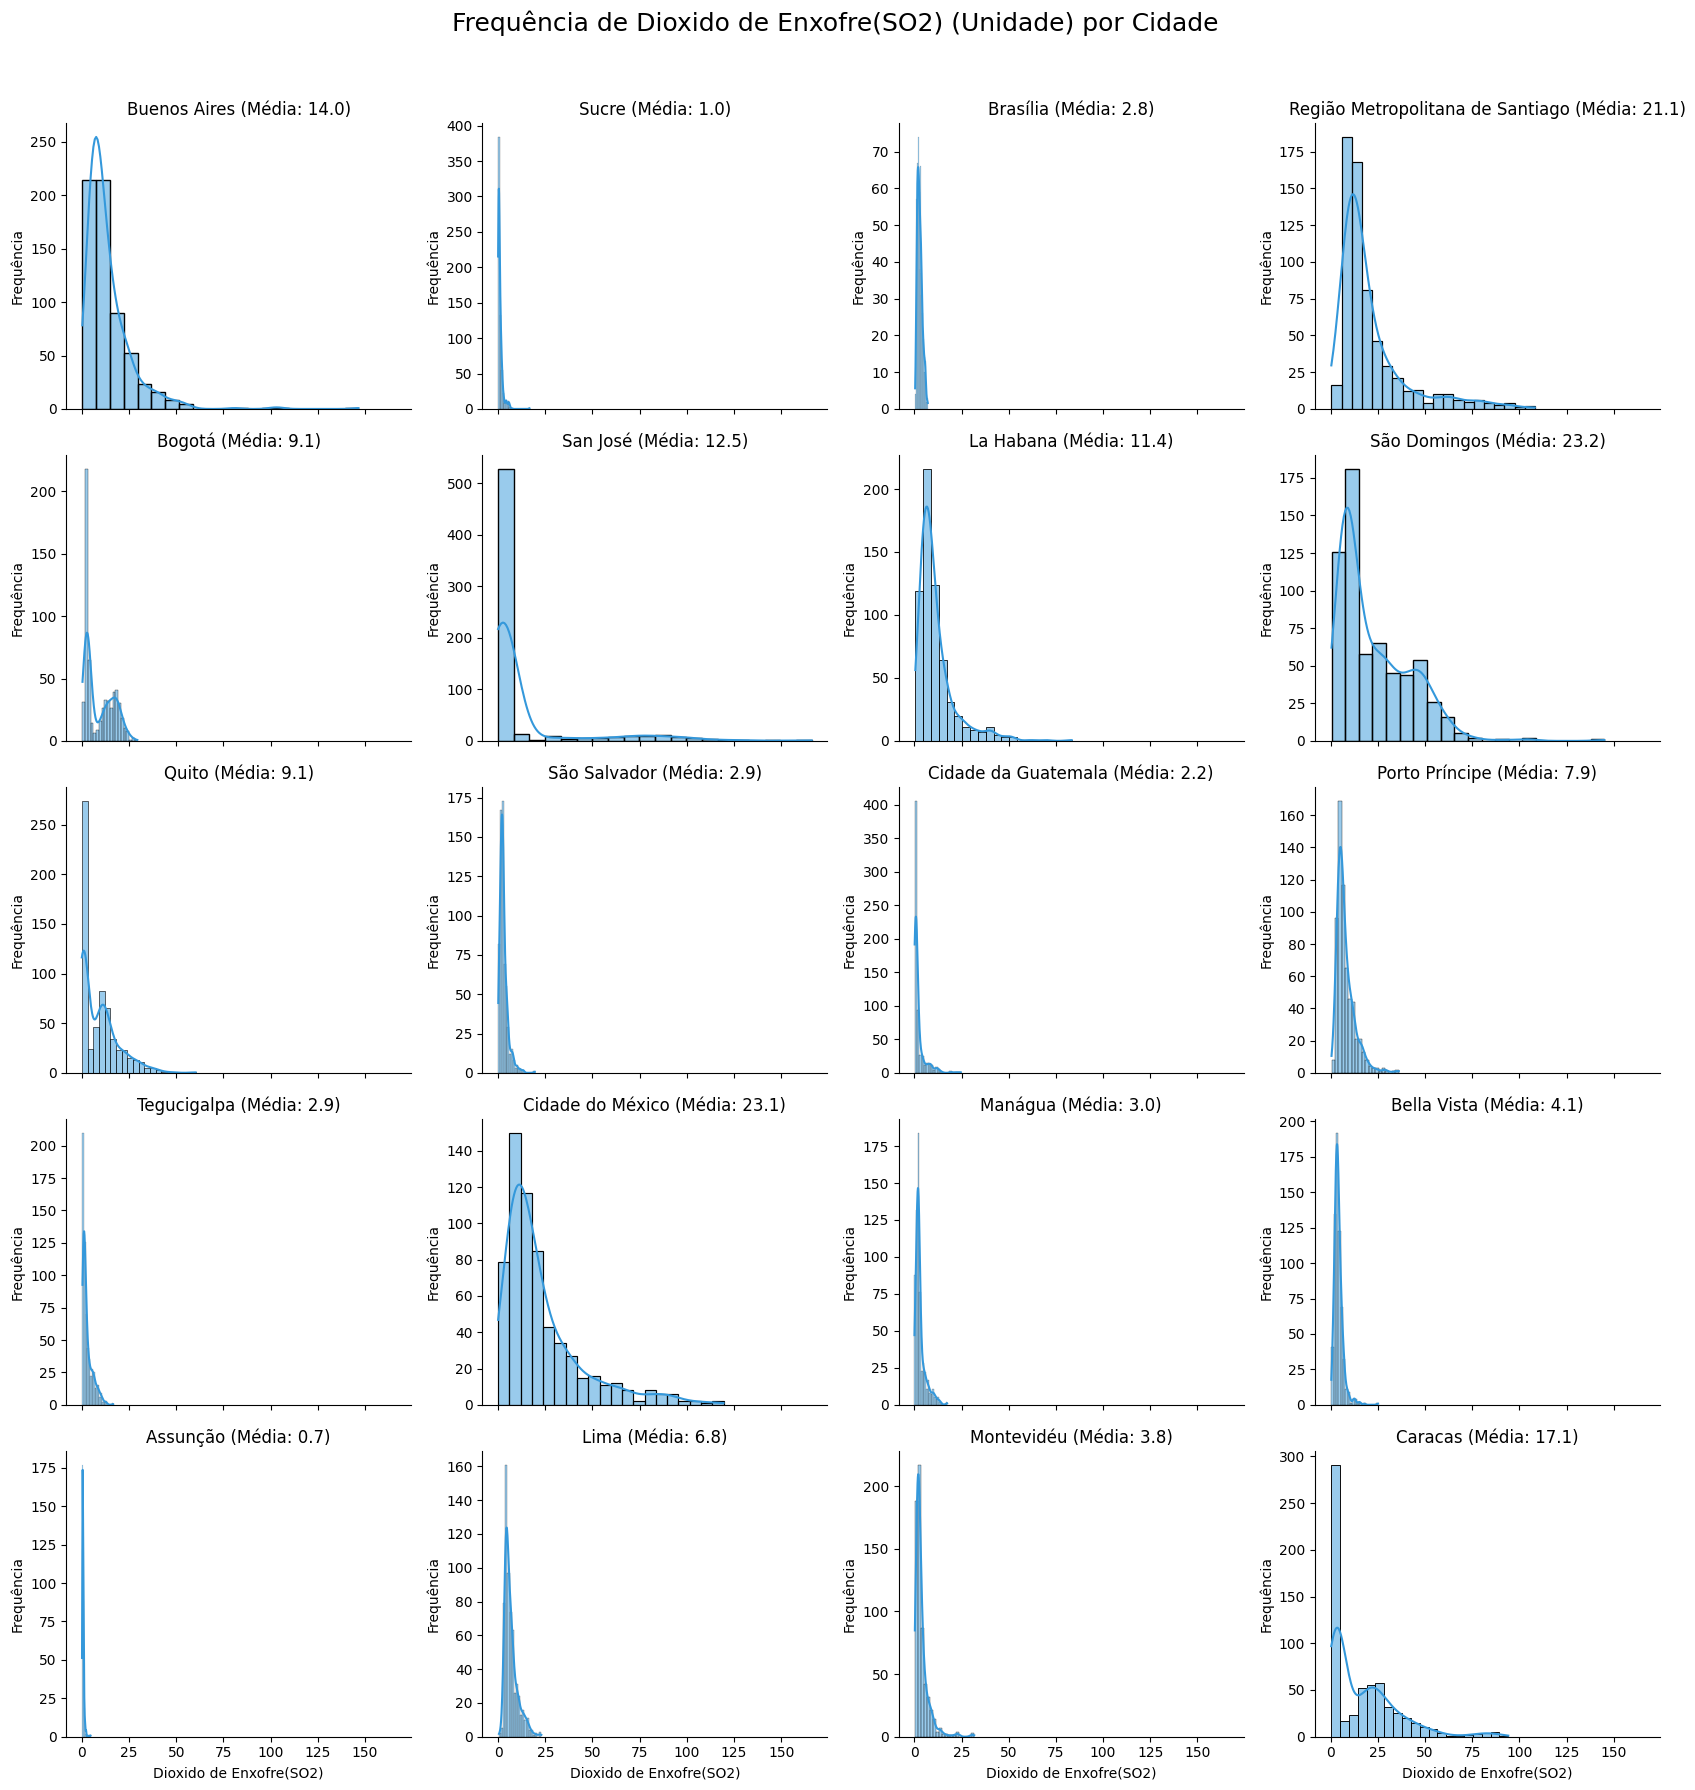

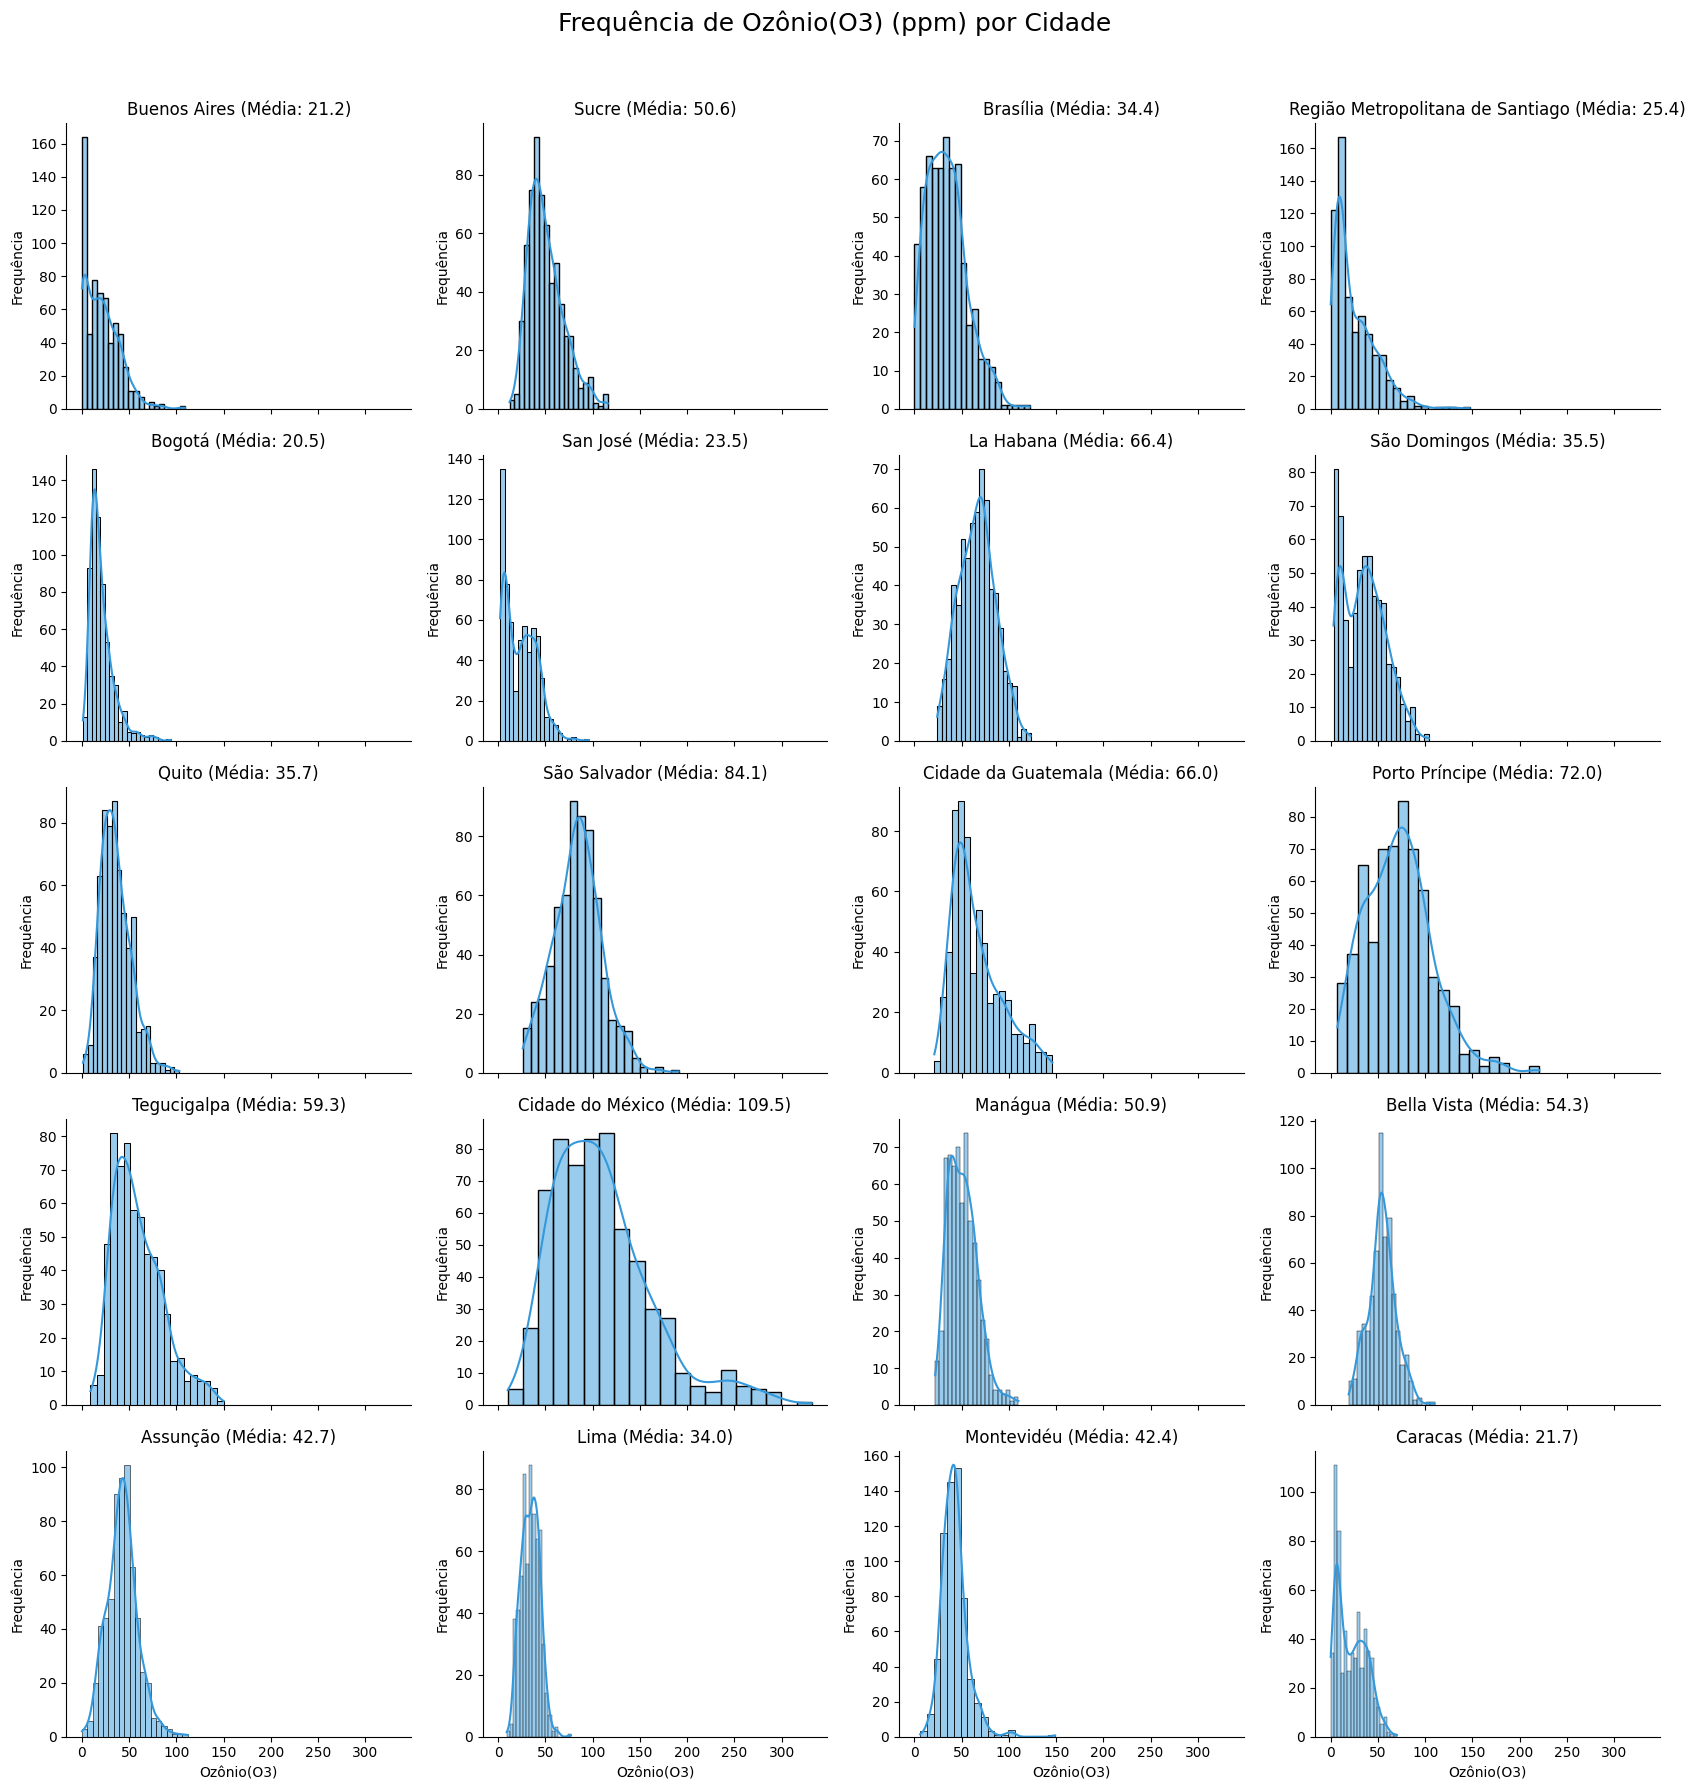

In [8]:
# --- 0. PREPARAÇÃO DE DADOS ---

# 1. Garantir que a coluna 'Data' seja do tipo datetime (necessário para a próxima fase de EDA, mas mantemos)
dados_clima['Data'] = pd.to_datetime(dados_clima['Data'], errors='coerce')
df_plot = dados_clima.dropna(subset=['Cidade']).copy()

# 2. IDENTIFICAÇÃO DOS INDICADORES (Ajuste esta lista conforme seu DataFrame)
indicadores_candidatos = ['PM10', 'PM2_5', 'Monóxido de Carbono (CO)', 'Dióxido de Nitrogênio (NO2)', 'Dioxido de Enxofre(SO2)', 'Ozônio(O3)']
colunas_disponiveis = df_plot.columns.tolist()
indicadores_poluicao = [ind for ind in indicadores_candidatos if ind in colunas_disponiveis]

# Mapeamento de unidade e título (para o gráfico ficar mais limpo)
unidades = {
    'PM10': 'μg/m³',
    'PM2_5': 'μg/m³',
    'Ozônio(O3)': 'ppm',
    'Dióxido de Nitrogênio (NO2)': 'ppm',
    'Monóxido de Carbono (CO2)': 'ppm',
    'Dióxido de Enxofre(SO2)':'ppm'
}

print(f"✅ Indicadores prontos para histogramas: {indicadores_poluicao}")

# --- 3. FUNÇÃO PARA GERAR O HISTOGRAMA COM FACETAMENTO POR CIDADE ---

def plot_histogramas_facetados(df, indicador, unidade):

    # Remove NaN apenas para o indicador atual e a cidade
    df_indicador = df.dropna(subset=[indicador, 'Cidade'])

    if df_indicador.empty:
        print(f"Aviso: Não há dados válidos para o indicador {indicador}. Gráfico ignorado.")
        return

    # Define o número de cidades e o tamanho do grid
    n_cidades = df_indicador['Cidade'].nunique()
    # Ajuste o tamanho da figura para acomodar o número de cidades (ex: 2 linhas, N/2 colunas)
    cols = min(4, n_cidades) # Máximo de 4 colunas
    rows = int(np.ceil(n_cidades / cols))

    # O FacetGrid é ideal para criar painéis de subplots baseados em uma categoria (Cidade)
    g = sns.FacetGrid(
        df_indicador,
        col="Cidade",
        col_wrap=cols, # Número de colunas no grid
        sharey=False,  # Permite que o eixo Y seja diferente para cada cidade (melhor para distribuição)
        height=3.5,
        aspect=1.2 # Aspecto mais largo
    )

    # Mapeia a função de histograma para cada painel
    g.map(
        sns.histplot,
        indicador,
        kde=True, # Adiciona a curva de densidade (suaviza a distribuição)
        bins=20,  # Número de caixas/intervalos
        color="#3498db" # Cor de fundo
    )

    # Adiciona títulos e ajusta layout
    titulo_principal = f'Frequência de {indicador} ({unidade.get(indicador, "Unidade")}) por Cidade'
    g.fig.suptitle(titulo_principal, fontsize=18, y=1.02)

    # Ajusta os rótulos de cada subplot (opcional)
    for ax in g.axes.flat:
        ax.set_xlabel(indicador, fontsize=10)
        ax.set_ylabel("Frequência", fontsize=10)
        # Adiciona a média no título do subplot para referência
        media = df_indicador.loc[df_indicador['Cidade'] == ax.get_title().split('=')[1].strip(), indicador].mean()
        ax.set_title(f"{ax.get_title().split('=')[1].strip()} (Média: {media:.1f})")

    plt.tight_layout() # Garante que os títulos e rótulos não se sobreponham
    plt.show()


# --- 4. EXECUÇÃO DO LOOP ---

for indicador in indicadores_poluicao:
    plot_histogramas_facetados(df_plot, indicador, unidades)

##### **Versão B: Gráfico de Violino**

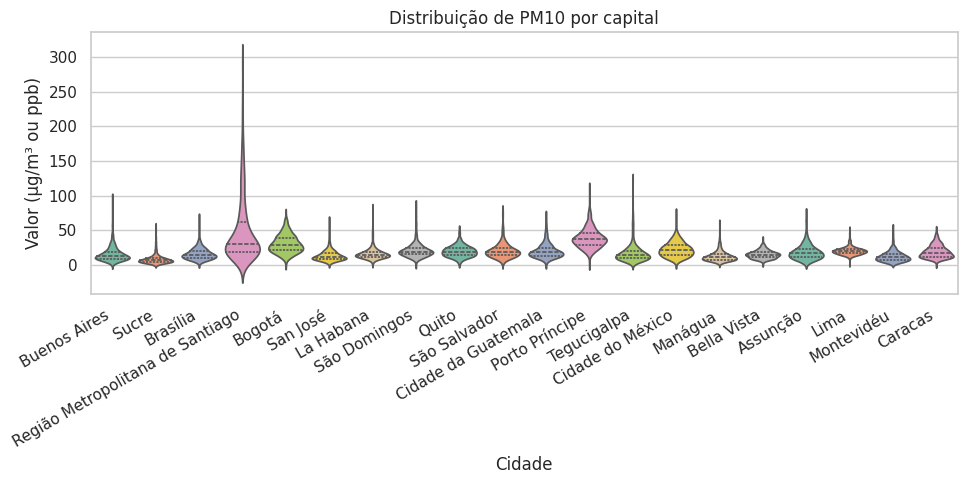

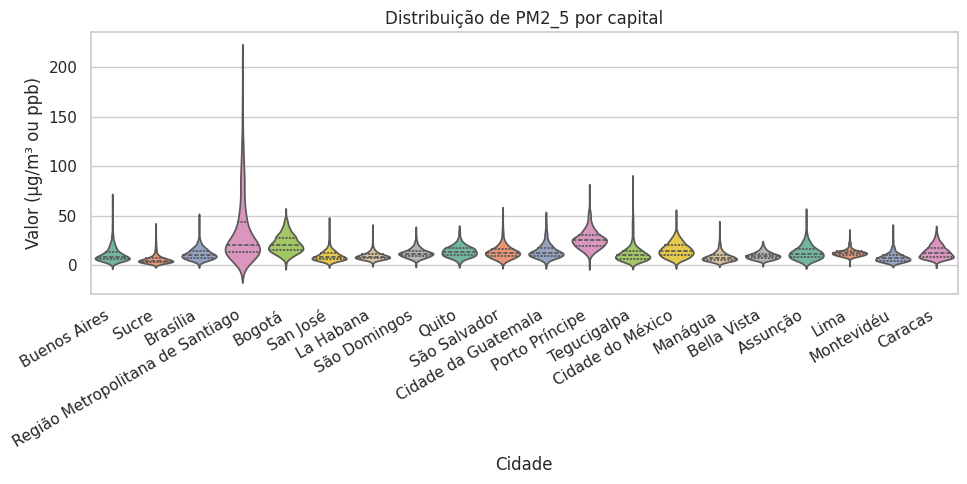

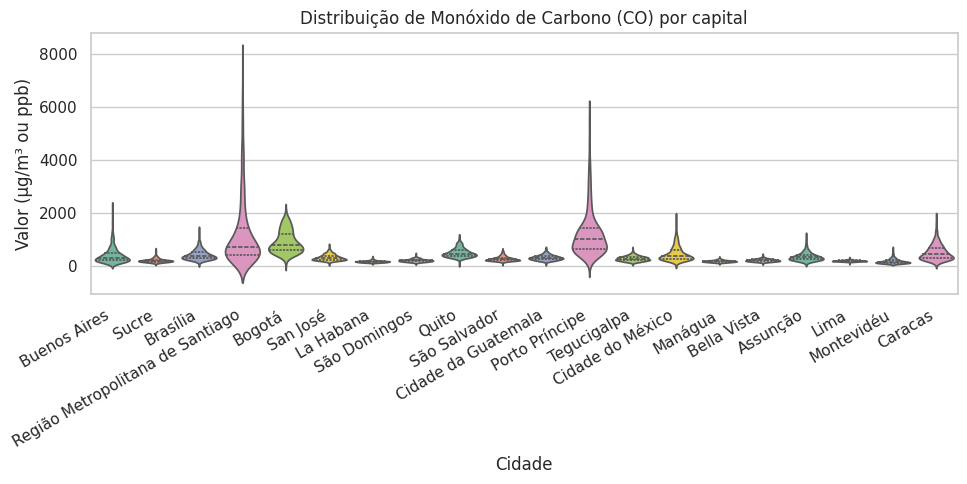

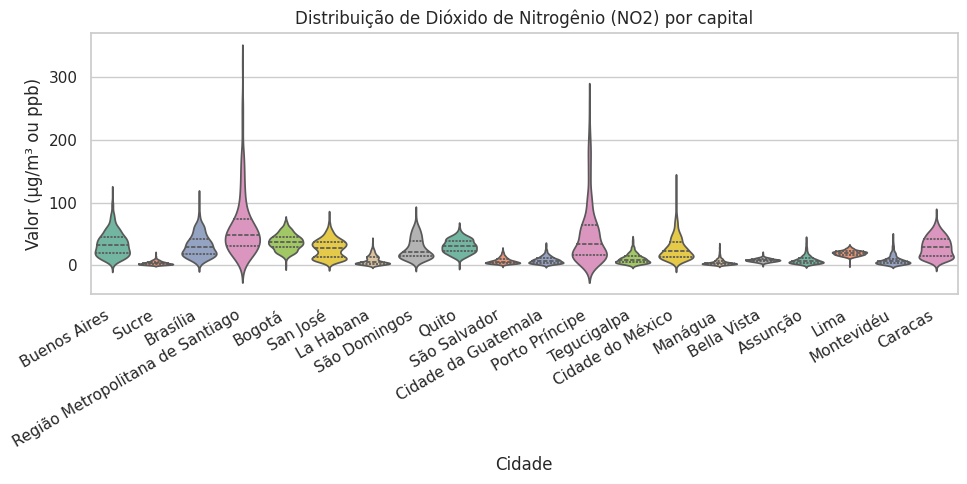

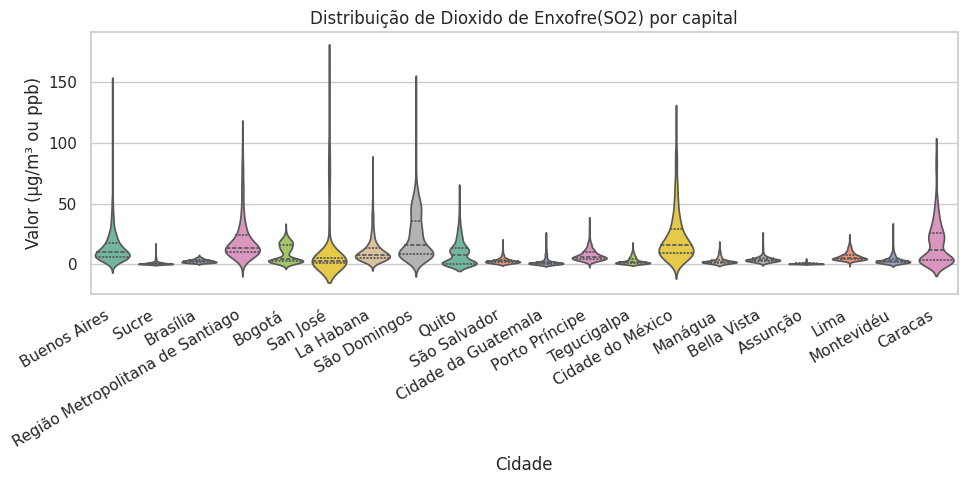

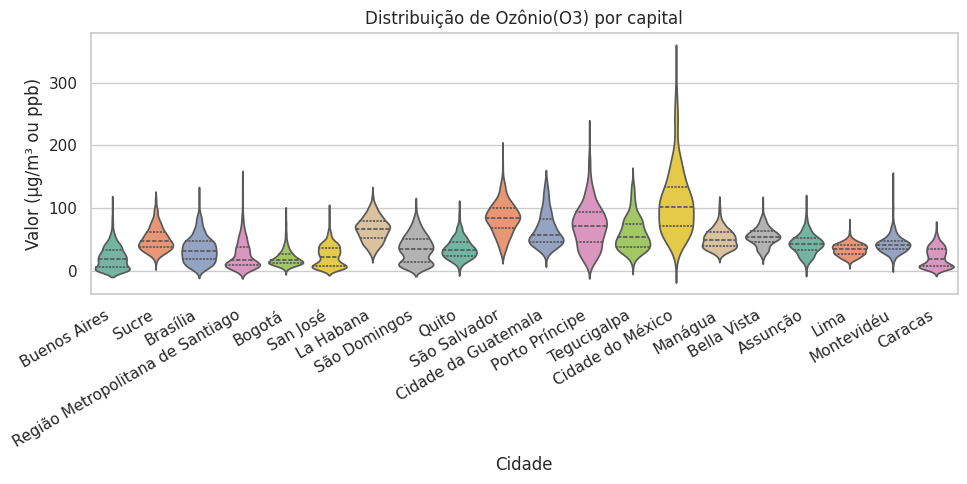

In [9]:
# Garantir que só existam linhas válidas
dados_longos = dados_longos.dropna(subset=["Valor", "Cidade"])

# Configurações de estilo
sns.set(style="whitegrid")

# Gerar um gráfico separado para cada indicador
indicadores = dados_longos["Indicador"].unique()

for indicador in indicadores:
    plt.figure(figsize=(10, 5))

    sns.violinplot(
        data=dados_longos[dados_longos["Indicador"] == indicador],
        x="Cidade", y="Valor",
        hue="Cidade",      # cores diferentes por cidade
        inner="quartile",
        palette="Set2",
        dodge=False        # mantém violinos sobrepostos ou separados
    )




    plt.title(f"Distribuição de {indicador} por capital")
    plt.xlabel("Cidade")
    plt.ylabel("Valor (μg/m³ ou ppb)")
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

### **2. Comparação da Sazonalidade na Concentração de Gases e Materiais Particulados entre Brasília e as demais capitais da América Latina**

#### **2.1. Análise de Sazonalidade: Distribuição e Dispersão Mensal de Gases e Material Particulado nas capitais da América Latina**

/tmp/ipython-input-3464166919.py:43: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




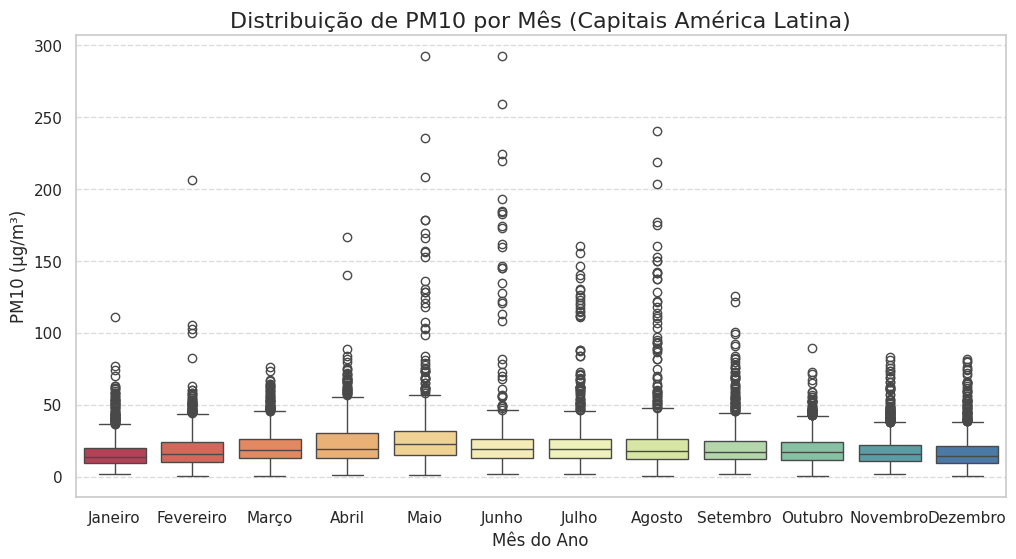

/tmp/ipython-input-3464166919.py:43: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




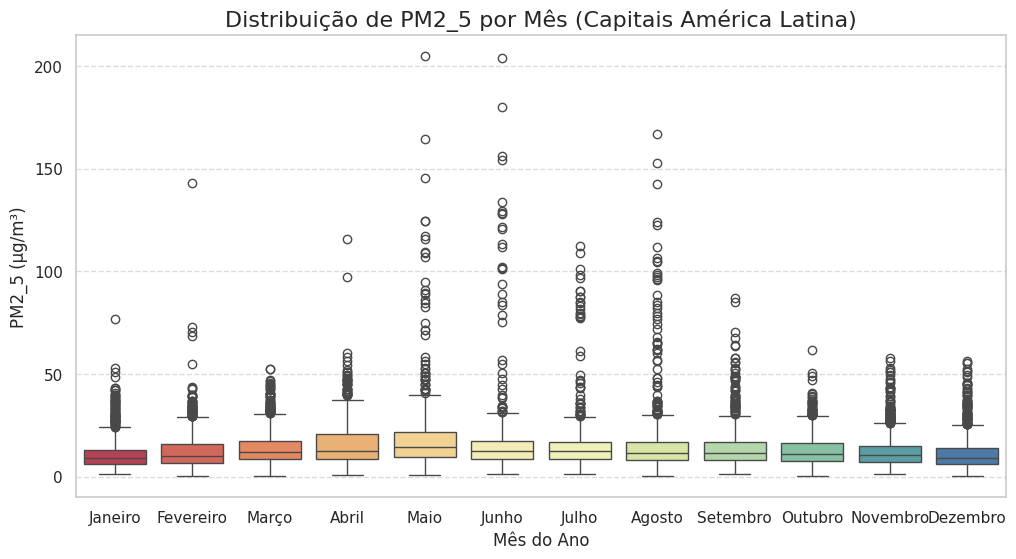

/tmp/ipython-input-3464166919.py:43: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




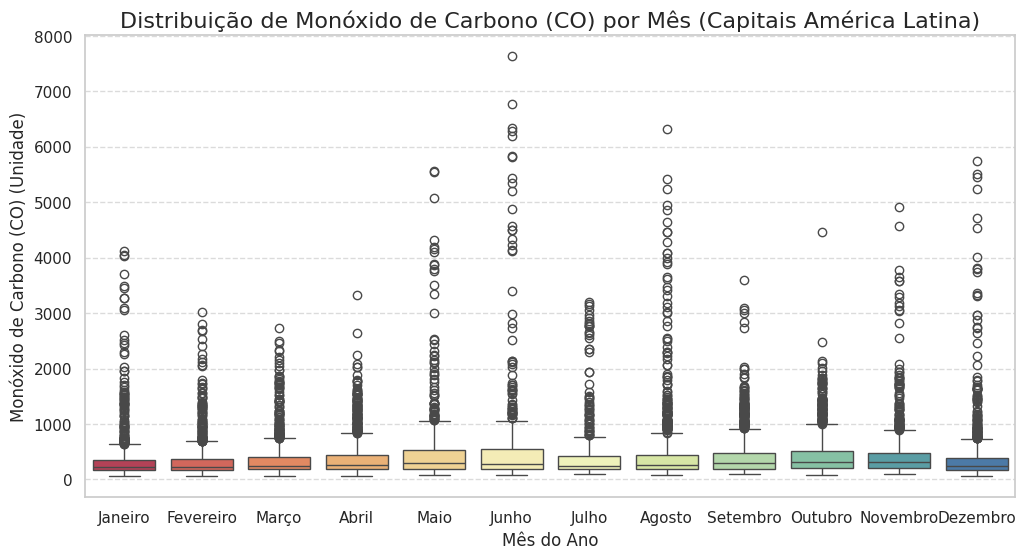

/tmp/ipython-input-3464166919.py:43: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




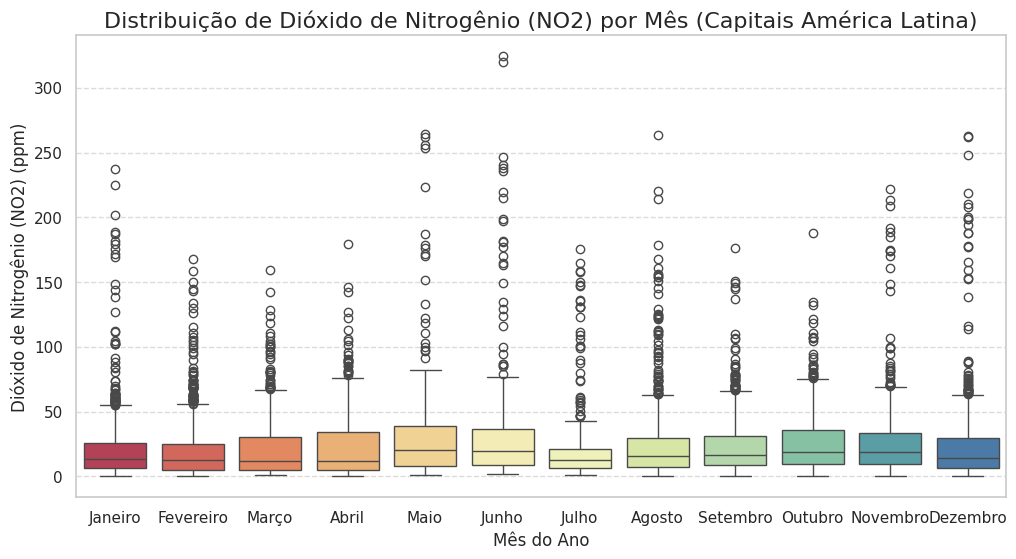

/tmp/ipython-input-3464166919.py:43: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




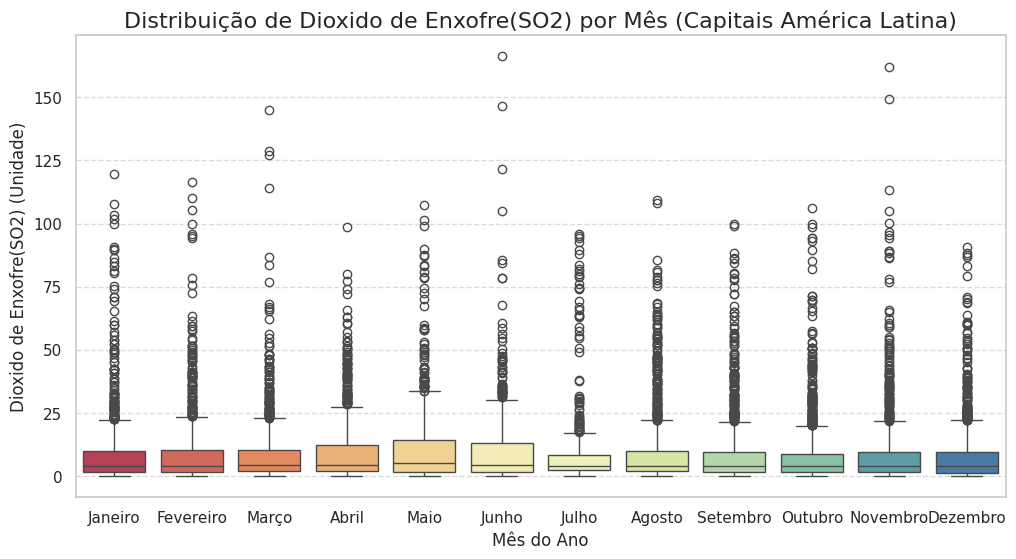

/tmp/ipython-input-3464166919.py:43: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




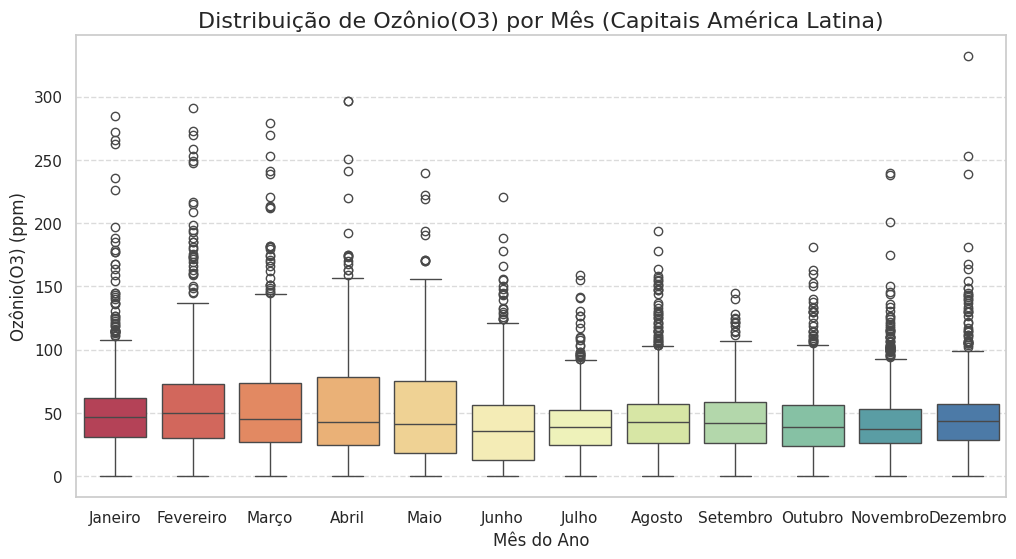

In [10]:
# --- 0. PRÉ-PROCESSAMENTO DE DADOS (Manter a extração de data) ---

# 1. Garantir que a coluna 'Data' seja do tipo datetime
dados_clima['Data'] = pd.to_datetime(dados_clima['Data'], errors='coerce')
# Não filtramos o PM10 ainda, pois faremos isso dinamicamente no loop
df_sazonal = dados_clima.dropna(subset=['Data']).copy()

# 2. DEFINIÇÃO DOS DICIONÁRIOS DE TRADUÇÃO
traducao_meses = {
    1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril', 5: 'Maio', 6: 'Junho',
    7: 'Julho', 8: 'Agosto', 9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'
}
# Extração das colunas em Português
df_sazonal['Mês_Nome'] = df_sazonal['Data'].dt.month.map(traducao_meses)
ordem_meses_pt = list(traducao_meses.values())

# 3. IDENTIFICAÇÃO DOS INDICADORES
# Lista de colunas que representam indicadores de poluição na sua base
indicadores_poluicao = ['PM10', 'PM2_5', 'Monóxido de Carbono (CO)', 'Dióxido de Nitrogênio (NO2)', 'Dioxido de Enxofre(SO2)', 'Ozônio(O3)']

# Mapeamento de unidade e título (para o gráfico ficar mais limpo)
unidades = {
    'PM10': 'μg/m³',
    'PM2_5': 'μg/m³',
    'Ozônio(O3)': 'ppm',
    'Dióxido de Nitrogênio (NO2)': 'ppm',
    'Monóxido de Carbono (CO2)': 'ppm',
    'Dióxido de Enxofre(SO2)':'ppm'
}

# --- 4. FUNÇÃO PARA GERAR O GRÁFICO POR INDICADOR ---

def plot_sazonal_por_indicador(df, indicador, ordem_eixo, unidade):
    # Remove NaN apenas para a coluna do indicador atual
    df_plot = df.dropna(subset=[indicador, 'Mês_Nome'])

    if df_plot.empty:
        print(f"Aviso: Não há dados válidos para o indicador {indicador}.")
        return

    plt.figure(figsize=(12, 6))

    sns.boxplot(
        data=df_plot,
        x='Mês_Nome',
        y=indicador,
        order=ordem_eixo,
        palette='Spectral'
    )

    # Cria o título e rótulo dinamicamente
    titulo = f'Distribuição de {indicador} por Mês (Capitais América Latina)'
    eixo_y = f'{indicador} ({unidade.get(indicador, "Unidade")})'

    plt.title(titulo, fontsize=16)
    plt.xlabel('Mês do Ano', fontsize=12)
    plt.ylabel(eixo_y, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


# --- 5. EXECUÇÃO DO LOOP ---

for indicador in indicadores_poluicao:
    # Obtém a unidade do indicador atual ou usa um valor padrão
    unidade_atual = unidades.get(indicador, 'Unidade')

    # Chama a função para gerar o gráfico Box Plot do Mês
    plot_sazonal_por_indicador(df_sazonal, indicador, ordem_meses_pt, unidades)

**Análise empírica dos resultados**

De modo geral, observa-se que a concentração média dos principais poluentes tende a variar ao longo do ano, revelando padrões sazonais consistentes entre os indicadores analisados.

- Mteriais particulados (`PM₁₀` e `PM₂.₅`): apresentam comportamento semelhante: ambos registram **pico na mediana de concentração em maio**, seguido de **queda acentuada na mediana e na dispersão em junho** e **redução gradual de ambos os indicadores até janeiro**, quando voltam a crescer. Esse padrão vai de acordo com os resultados do estudo [Atmospheric effects of air pollution during dry and wet periods in São Paulo (Brasil)](https://pubs.rsc.org/en/content/articlehtml/2022/ea/d1ea00080b?utm_source=chatgpt.com), que mostrou que a medida de concentração de material particulado no ar está associado ao **início do período mais úmido** (janeiro-maio), ligado ao verão e ao princípio do outono em território brasileiro, **quando a precipitação aumenta** e ajuda a remover partículas suspensas do ar, reduzindo suas concentrações. Esse padrão climático, por razões geográficas, também se faz presente em outros países latino-americanos, o que pode ajudar a explicar o comportamento visualizado nos gráficos.

- `Monóxido de carbono (CO)`: apresenta **distribuição mais estável** ao longo do ano, com **maior variância entre maio e agosto** e novamente de **novembro a janeiro**, sugerindo **flutuações ligadas ao volume de tráfego urbano e à queima de combustíveis**. O mês de junho se destaca por menor variabilidade, possivelmente devido à maior dispersão atmosférica típica dessa época em algumas capitais.

- `Dióxido de nitrogênio (NO₂)`: segue padrão semelhante ao do CO, com **baixa variância em junho**, reforçando a hipótese de que **condições meteorológicas favoráveis à dispersão dos poluentes** (como ventos e menor estabilidade térmica) contribuem para essa redução.

- `Dióxido de enxofre (SO₂)`: exibe **maior variância no primeiro semestre** e **redução no segundo**, o que pode refletir a **intensidade das atividades industriais e termelétricas**, mais elevadas nos meses iniciais, além de **efeitos de dispersão e diluição atmosférica** nos meses mais quentes.

- `Ozônio (O₃)`: mantém padrão similar, porém com **variância mais elevada no geral**, o que é coerente com o fato de ser um **poluente secundário**, formado a partir de reações fotoquímicas envolvendo outros gases sob **incidência solar intensa** — especialmente durante os meses de maior radiação.

Por fim, nota-se que as **medianas tendem a ser menores no segundo semestre**, o que sugere que as condições climáticas desse período favorecem a dispersão e remoção dos poluentes atmosféricos, contribuindo para uma melhora geral na qualidade do ar.

#### **2.2. Concentração Semanal de Gases e Material Particulado nas Capitais Latino-americanas (exceto Brasília)**

##### **2.2.1 Capitais latino-americanas (exceto Brasília)**

Iniciando a geração dos Calendar Heatmaps para a Média das Capitais (Exceto Brasília)...


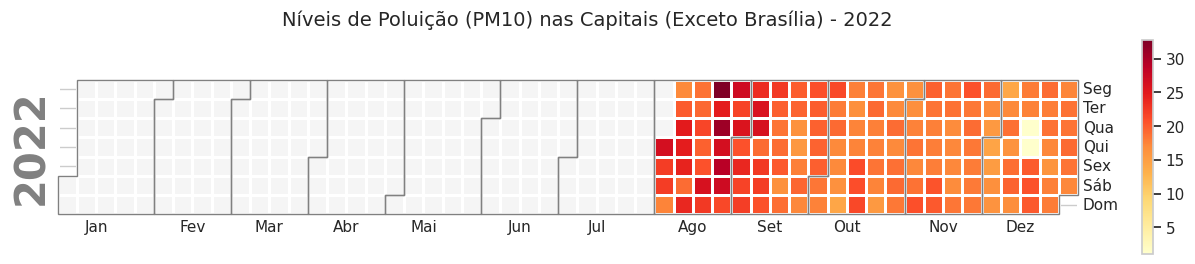

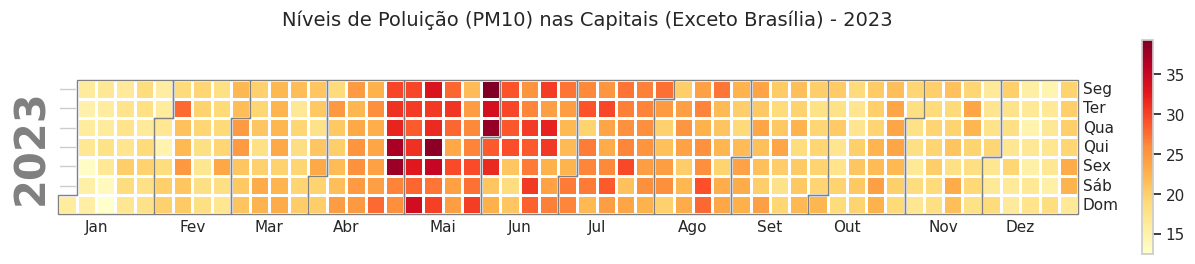

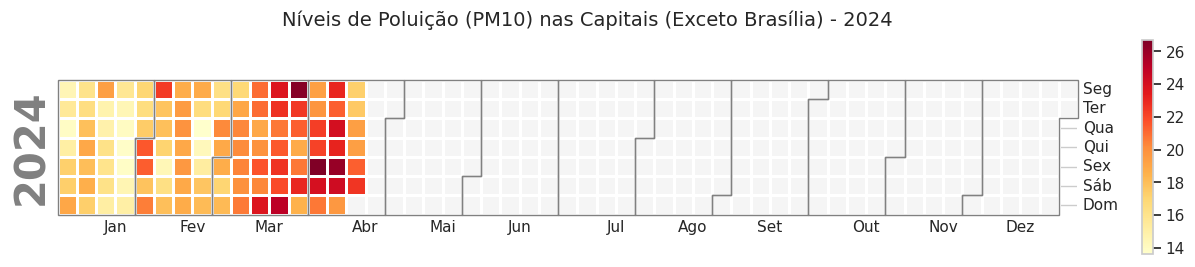

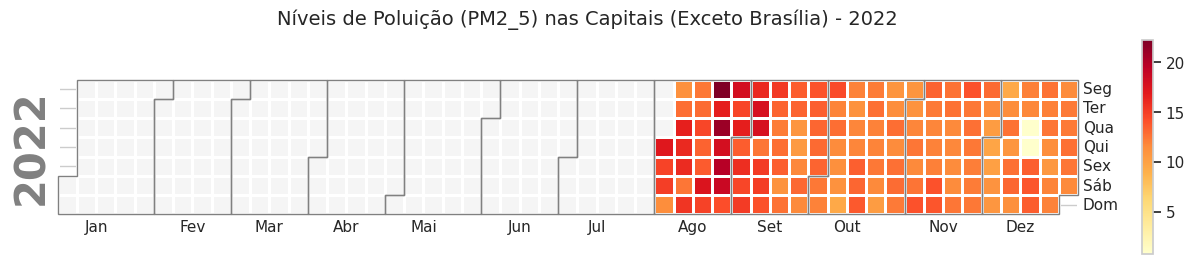

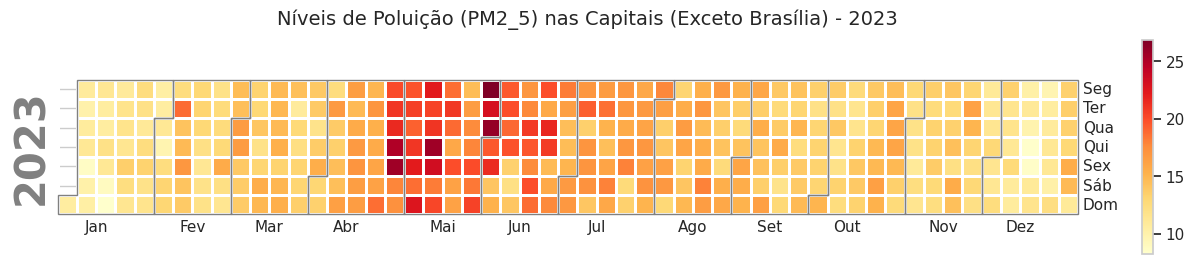

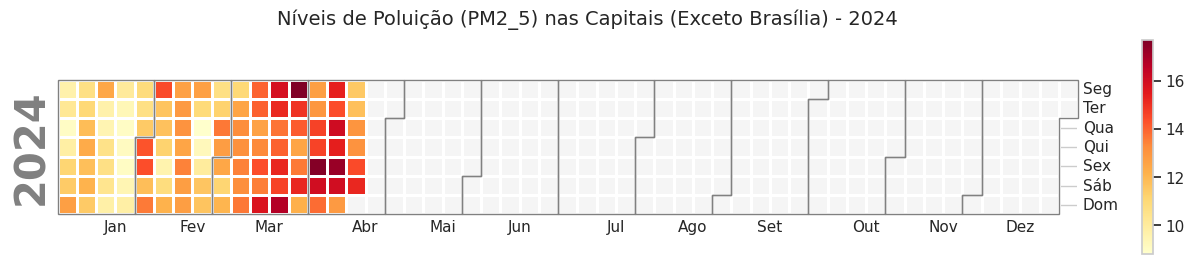

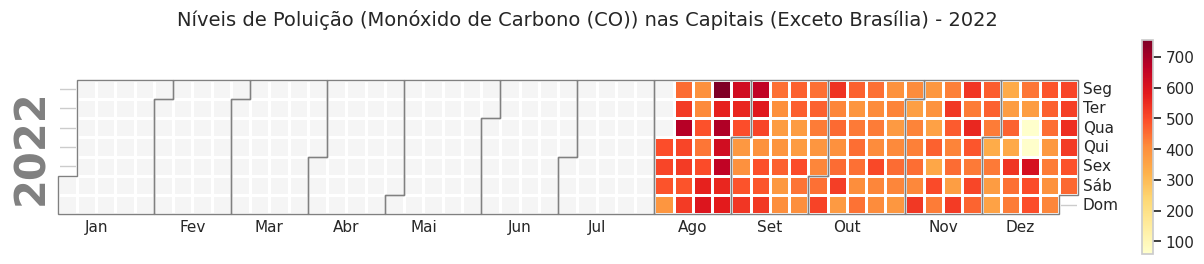

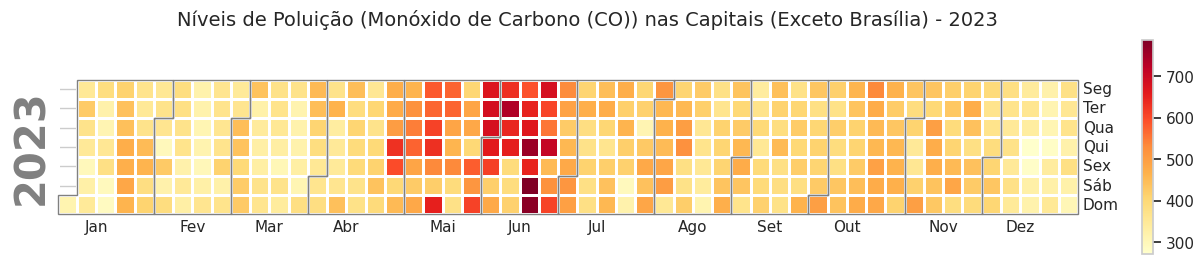

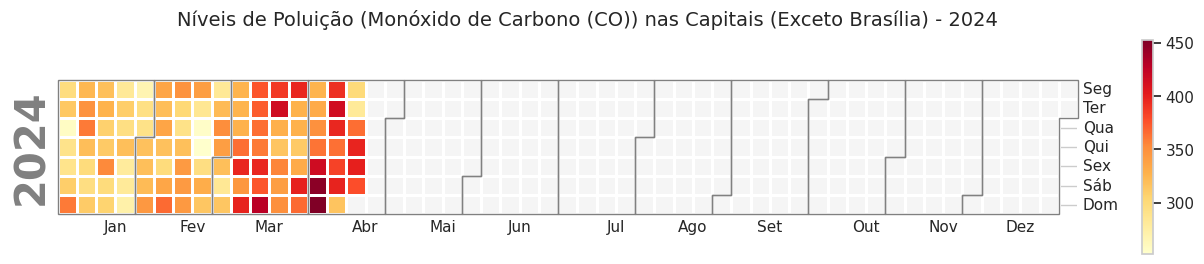

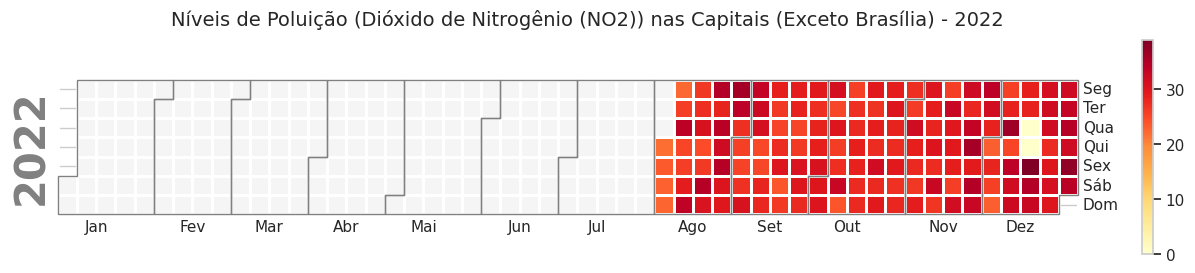

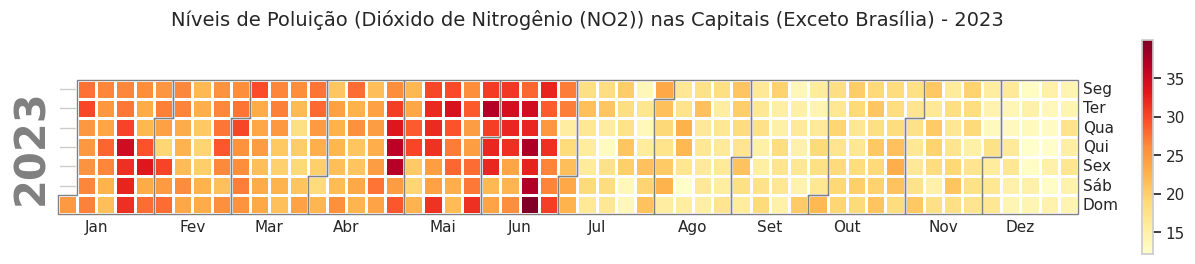

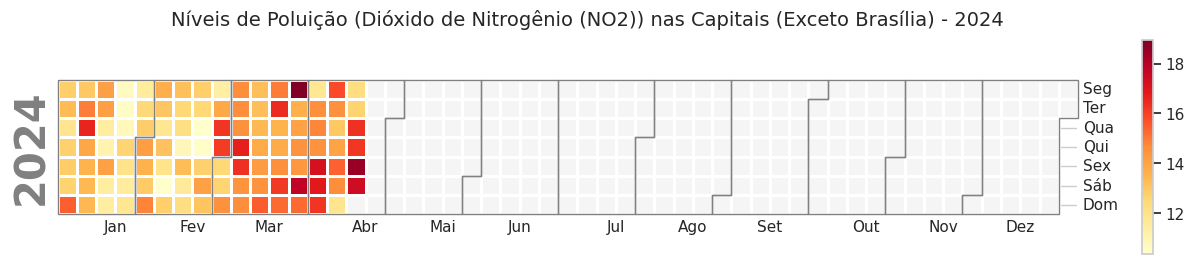

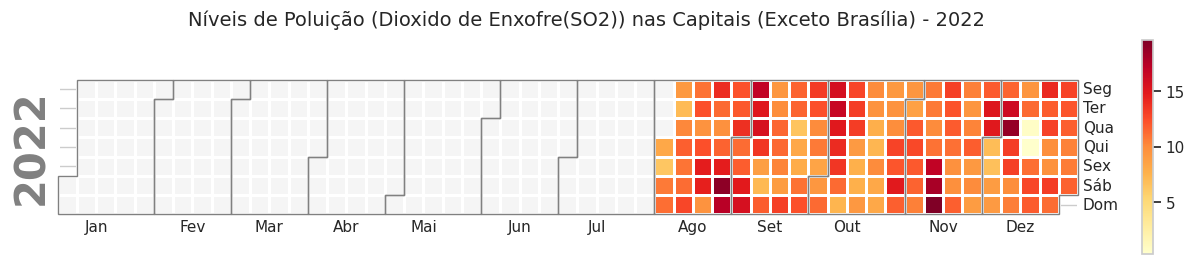

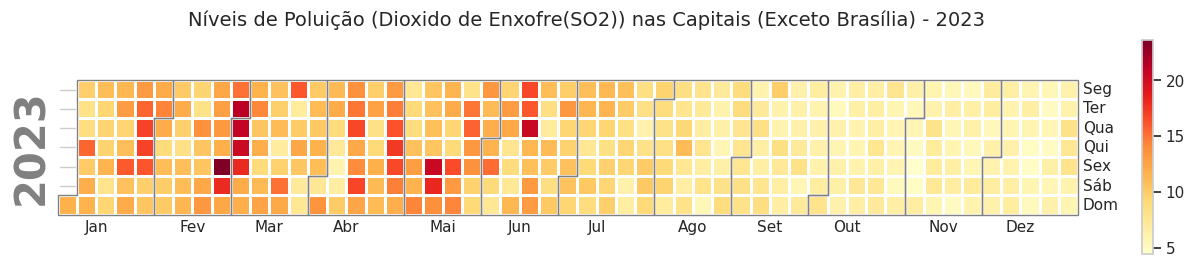

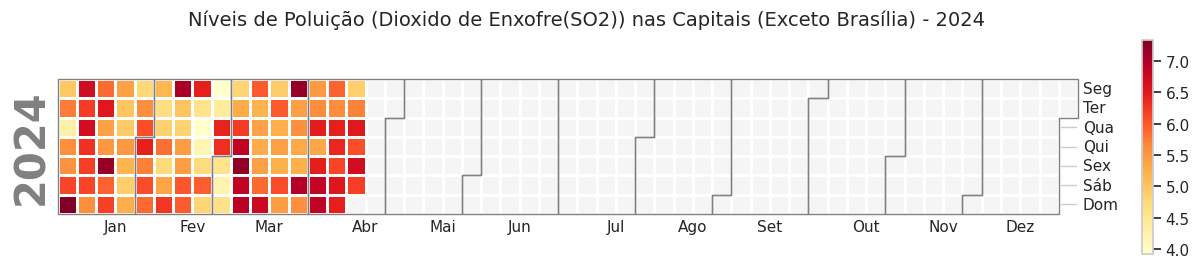

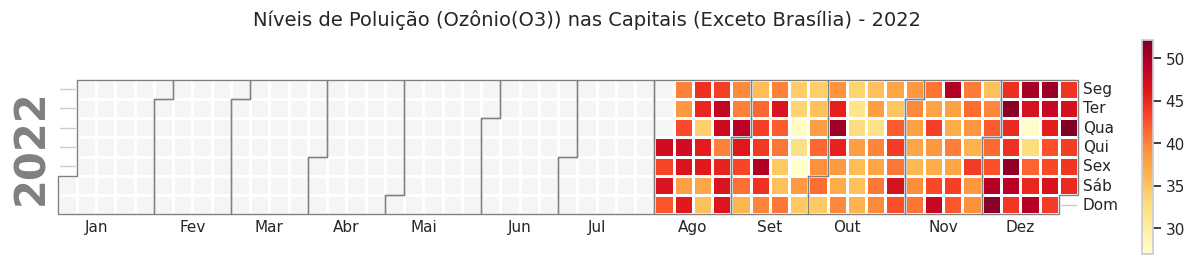

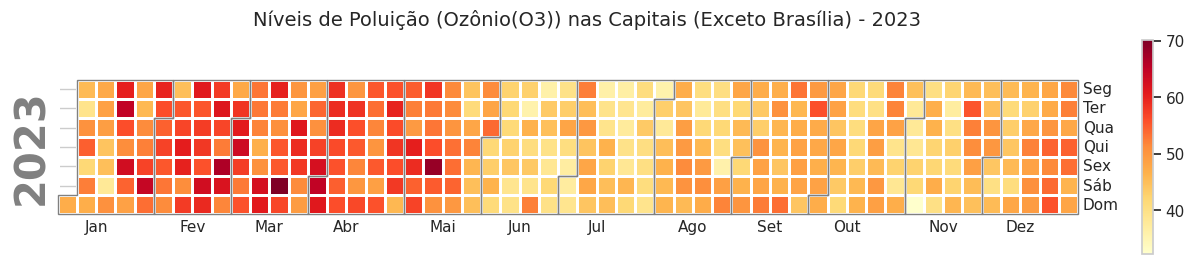

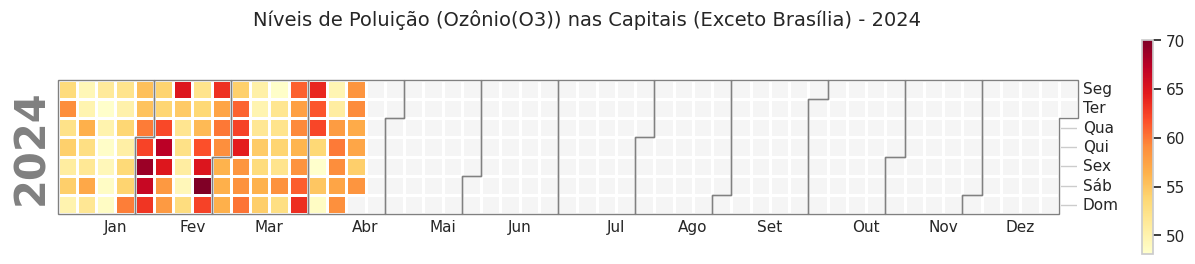


Processo concluído.


In [16]:
import pandas as pd
import calplot
import matplotlib.pyplot as plt
import logging

# Silenciar warnings de fonte (ajuda na limpeza da saída)
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
logging.getLogger('calplot').setLevel(logging.ERROR)


# --- 1. PRE-PROCESSAMENTO E FILTRAGEM ---

# Copia a base de dados
dados_climacp = dados_clima.copy()

# Garantir que a coluna 'Data' seja datetime e remover fuso horário para compatibilidade com calplot
dados_climacp['Data'] = pd.to_datetime(dados_climacp['Data'], utc=True).dt.tz_localize(None)

# 1. Filtro: Excluir Brasília e remover NaNs em Cidade/Data
df_filtrado = dados_climacp[dados_climacp['Cidade'] != 'Brasília'].copy()
df_filtrado.dropna(subset=['Data', 'Cidade'], inplace=True)

# 2. Agrupamento Diário: Calcule a média diária do poluente em TODAS as capitais
# Isso cria uma série temporal única para a "América Latina (Exceto Brasília)"
# O calplot só aceita uma única série temporal (média ou soma por dia).
df_series_temporais = df_filtrado.groupby('Data').mean(numeric_only=True).reset_index()


# --- 2. DEFINIÇÕES ---

poluentes = [
    'PM10',
    'PM2_5',
    'Monóxido de Carbono (CO)',
    'Dióxido de Nitrogênio (NO2)',
    'Dioxido de Enxofre(SO2)',
    'Ozônio(O3)'
]

anos = [2022, 2023, 2024]
cmap_padrao = 'YlOrRd' # Cor amarela/laranja/vermelha é ideal para poluição

# --- 3. GERAÇÃO DO CALENDAR HEATMAP COM CALPLOT ---

print("Iniciando a geração dos Calendar Heatmaps para a Média das Capitais (Exceto Brasília)...")

for poluente in poluentes:

    # Verifica se o poluente existe na série temporal agregada
    if poluente not in df_series_temporais.columns:
        print(f"⚠️ Aviso: Coluna '{poluente}' não encontrada. Pulando.")
        continue

    # Criar uma cópia da série de valores
    df_poluente = df_series_temporais[['Data', poluente]].dropna()

    # 3.1. Setar o índice para 'Data' (Requisito do calplot)
    df_poluente.set_index('Data', inplace=True)
    values = df_poluente[poluente]

    # 3.2. Loop por ano
    for ano in anos:

        # Filtra a série temporal para o ano específico
        values_ano = values[values.index.year == ano]

        if values_ano.empty:
            print(f"   Dados insuficientes para {poluente} em {ano}. Pulando.")
            continue

        # Geração do gráfico calplot
        calplot.calplot(
            values_ano,
            cmap=cmap_padrao,
            daylabels=['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom'],
            monthlabels=['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'],
            suptitle=f'Níveis de Poluição ({poluente}) nas Capitais (Exceto Brasília) - {ano}',
            suptitle_kws={'fontsize': 14, 'y': 1.05},
            figsize=(14, 2.5) # Ajusta o tamanho do gráfico anual
        )

        plt.show()

print("\nProcesso concluído.")

##### **2.2.2 Brasília**

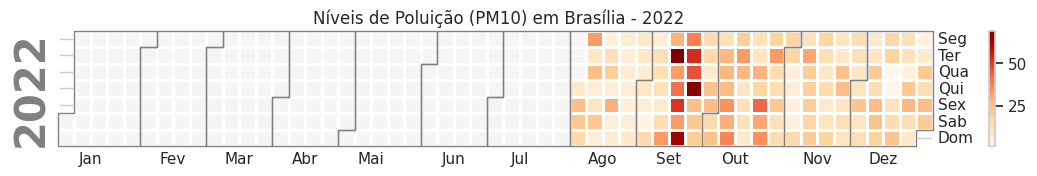

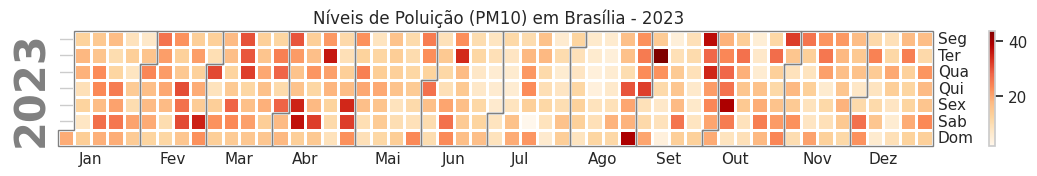

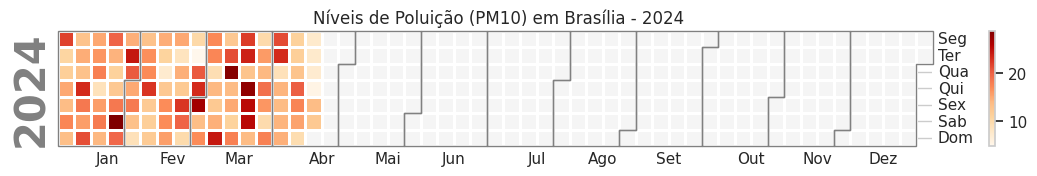

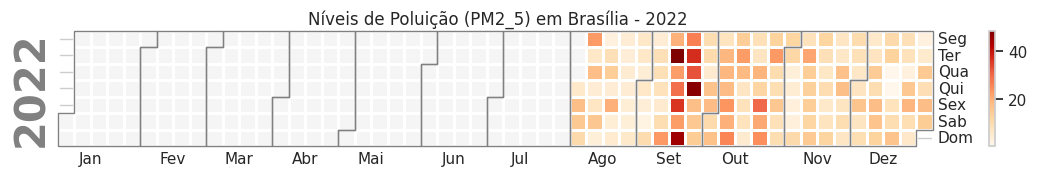

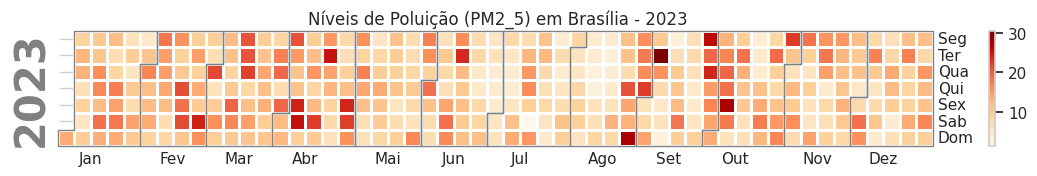

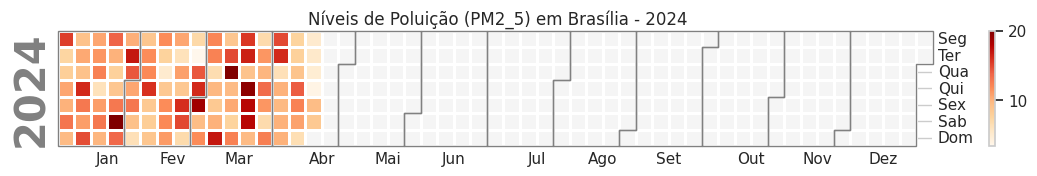

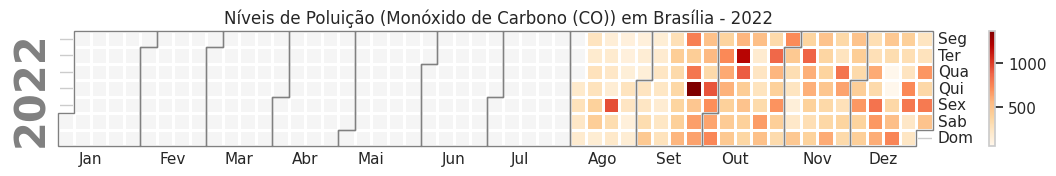

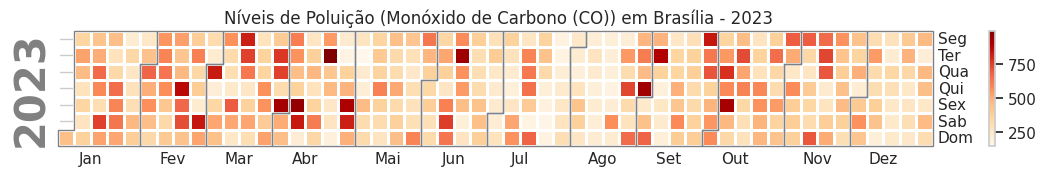

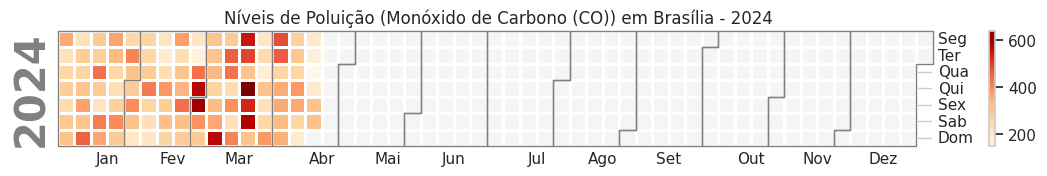

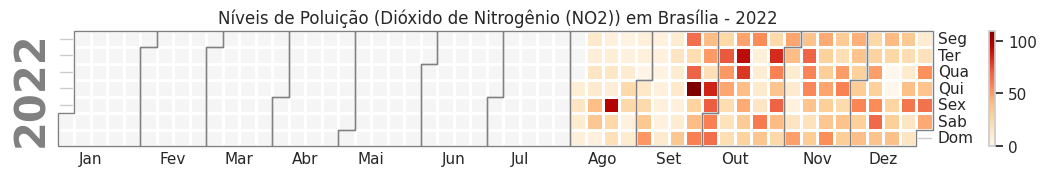

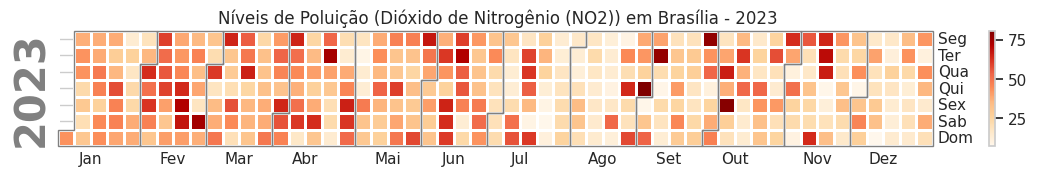

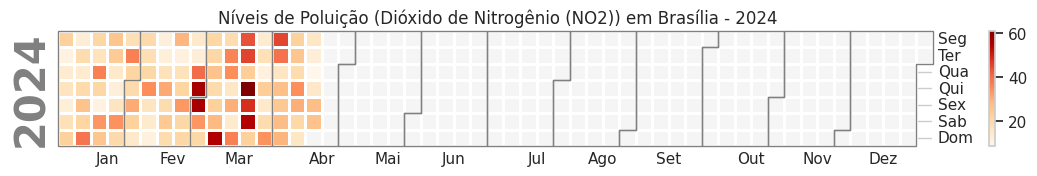

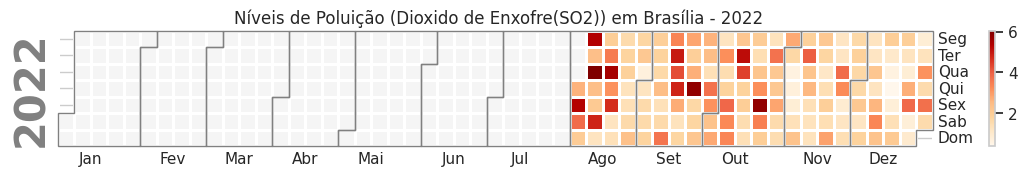

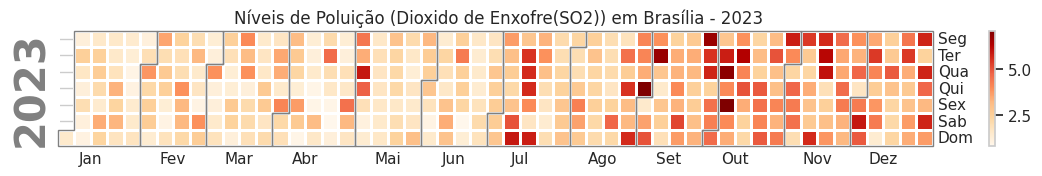

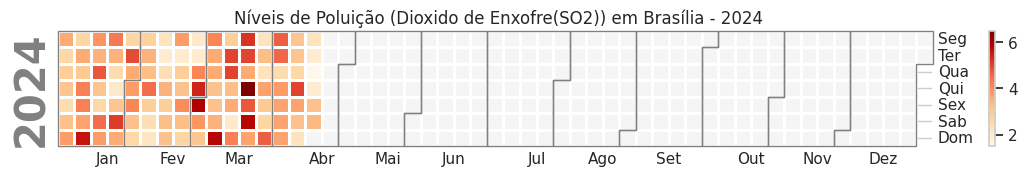

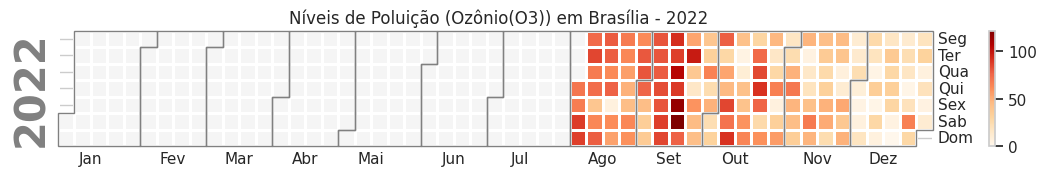

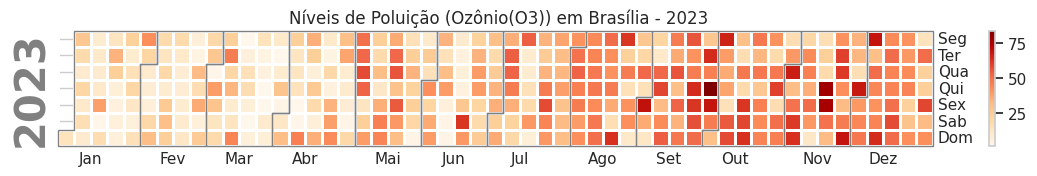

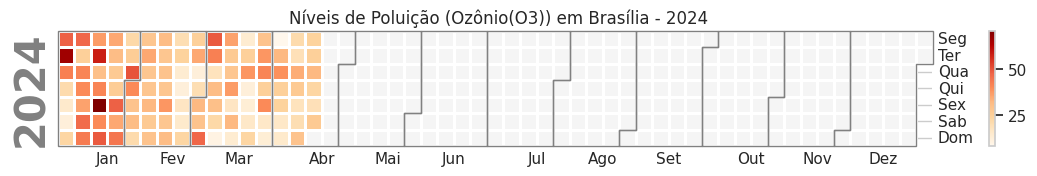

In [13]:
# Calendar heatmap com calplot para Brasília (teste) - ver se é visualmente mais atrativo
import pandas as pd
import calplot
import matplotlib.pyplot as plt
import logging

# Silenciar warnings de fonte
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

dados_climacp = dados_clima.copy()
# Garantir que data é datetime
dados_climacp['Data'] = pd.to_datetime(dados_climacp['Data'])
# Tirando fuso
dados_climacp['Data'] = dados_climacp['Data'].dt.tz_localize(None)
# Filtrar Brasília
df_brasilia = dados_climacp[dados_climacp['Cidade'] == 'Brasília'].copy()
# Lista dos poluentes
poluentes = [
    'PM10',
    'PM2_5',
    'Monóxido de Carbono (CO)',
    'Dióxido de Nitrogênio (NO2)',
    'Dioxido de Enxofre(SO2)',
    'Ozônio(O3)'
]
# Gerar calendar heatmap para cada poluente em cada ano
anos = [2022, 2023, 2024]
for poluente in poluentes:
  for ano in anos:
    df_ano = df_brasilia[df_brasilia['Data'].dt.year == ano].copy()
    df_ano.set_index('Data', inplace=True)
    values = df_ano[poluente].dropna()
    calplot.calplot(
        values,
        cmap='OrRd',
        daylabels=['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sab', 'Dom'],
        monthlabels=['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'],
        suptitle=f'Níveis de Poluição ({poluente}) em Brasília - {ano}',
        suptitle_kws={'fontsize': 12, 'y': 1.02}
    )

**Análise empírica dos resultados**

- `Capitais latino-americanas`: as **maiores concentrações de poluentes ocorreram no mês de maio**, indicando um possível aumento das emissões ou condições climáticas menos favoráveis à dispersão nesse período.
- `Brasília`: o **pico de concentração foi observado em setembro**, mês que coincide com a estação seca no Centro-Oeste, caracterizada por baixos níveis de umidade, maior ocorrência de queimadas e menor ventilação, fatores que favorecem o acúmulo de poluentes na atmosfera.

### **3. Comparação de Brasília e outras capitais usando métricas de Avaliação da Qualidade do Ar**

Após analisar como, temporalmente, a distribuição dos gases e dos materiais particulares se comportam nas capitais latino-americanas, é de nosso interesse obter limiares que permitam a metrificação da situação das capitais no que diz respeito à concentração de indicadores de risco à saúde humana. Para isto, utilizamos, como referência, os limites de alerta mais recentemente atualizados pela Organização Mundial de Saúde (OMS) em 2021. Abaixo, segue tabela caracterizando estes pontos de corte:

| **Poluente**                  | **Período de média**                 | **Limite OMS 2021** | **Situação se ultrapassado** |
|-------------------------------|-------------------------------------|---------------------|------------------------------|
| **Material Particulado PM₂.₅** | 24 horas                            | 15 µg/m³            | Não aceitável                |
|                               | Média anual                         | 5 µg/m³             | Não aceitável                |
| **Material Particulado PM₁₀** | 24 horas                            | 45 µg/m³            | Não aceitável                |
|                               | Média anual                         | 15 µg/m³            | Não aceitável                |
| **Dióxido de Nitrogênio (NO₂)** | 24 horas                          | 25 µg/m³            | Não aceitável                |
|                               | Média anual                         | 10 µg/m³            | Não aceitável                |
| **Ozônio troposférico (O₃)**  | 8 horas (média máxima diária)        | 100 µg/m³           | Não aceitável                |
| **Dióxido de Enxofre (SO₂)**  | 24 horas                            | 40 µg/m³            | Não aceitável                |
| **Monóxido de Carbono (CO)**  | 24 horas                            | 4 mg/m³             | Não aceitável                |


- **Observação:** Os dados acima estão disponíveis para consulta através do documento oficial, [
WHO global air quality guidelines: particulate matter (‎PM2.5 and PM10)‎, ozone, nitrogen dioxide, sulfur dioxide and carbon monoxide
](https://www.who.int/publications/i/item/9789240034228?utm_source=chatgpt.com).

Os gráficos abaixo apresentam a proporção de todos os dias registrados no dataframe, em que a concentração de um dos indicadores estudados ultrapassou os limites de alerta da OMS.

✅ Indicadores a serem analisados: ['PM10', 'PM2_5', 'Dióxido de Nitrogênio (NO2)', 'Ozônio(O3)', 'Monóxido de Carbono (CO)', 'Dioxido de Enxofre(SO2)']


/tmp/ipython-input-2898052291.py:54: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



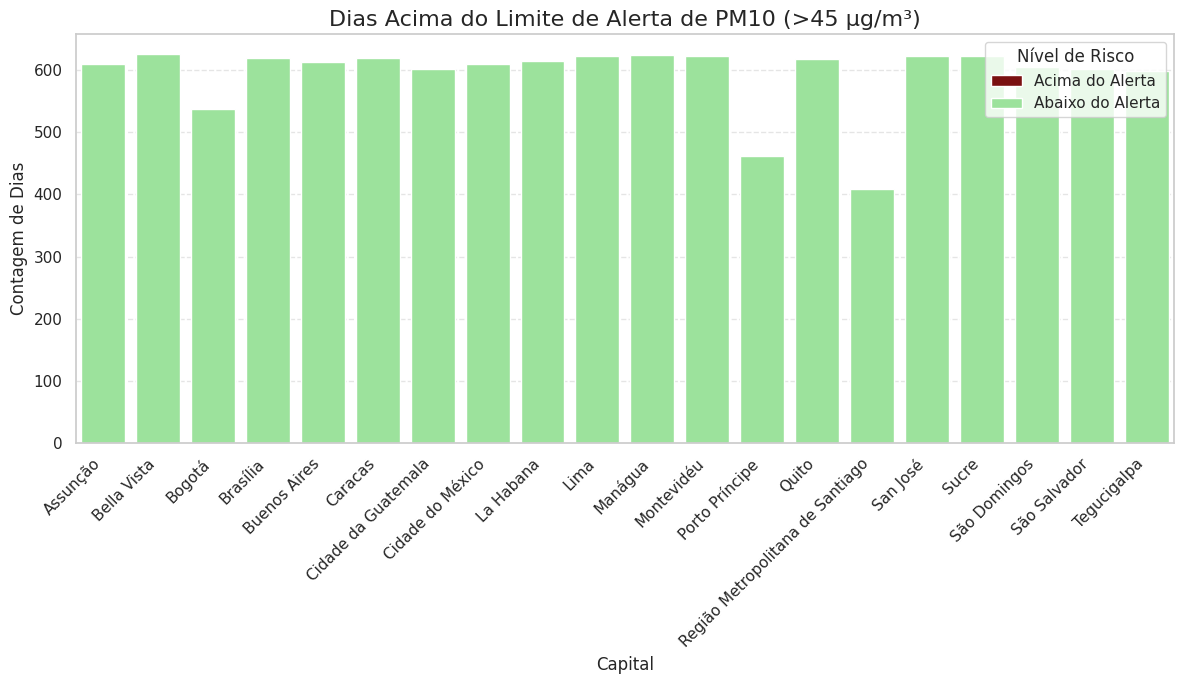

/tmp/ipython-input-2898052291.py:54: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



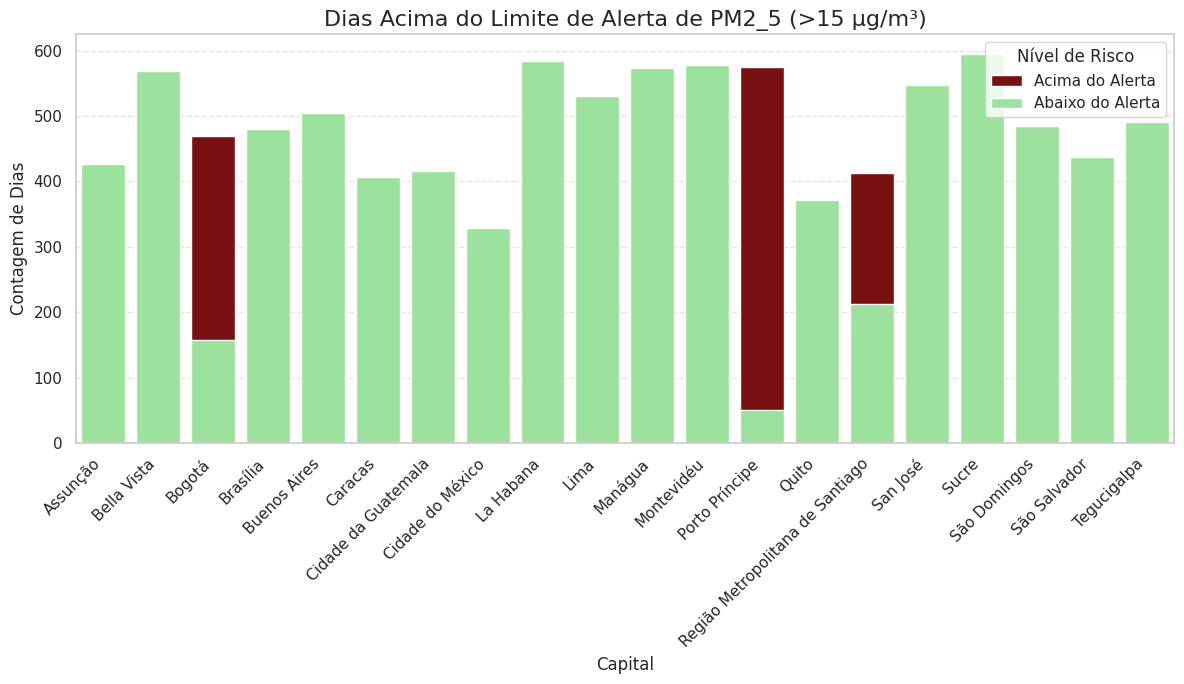

/tmp/ipython-input-2898052291.py:54: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



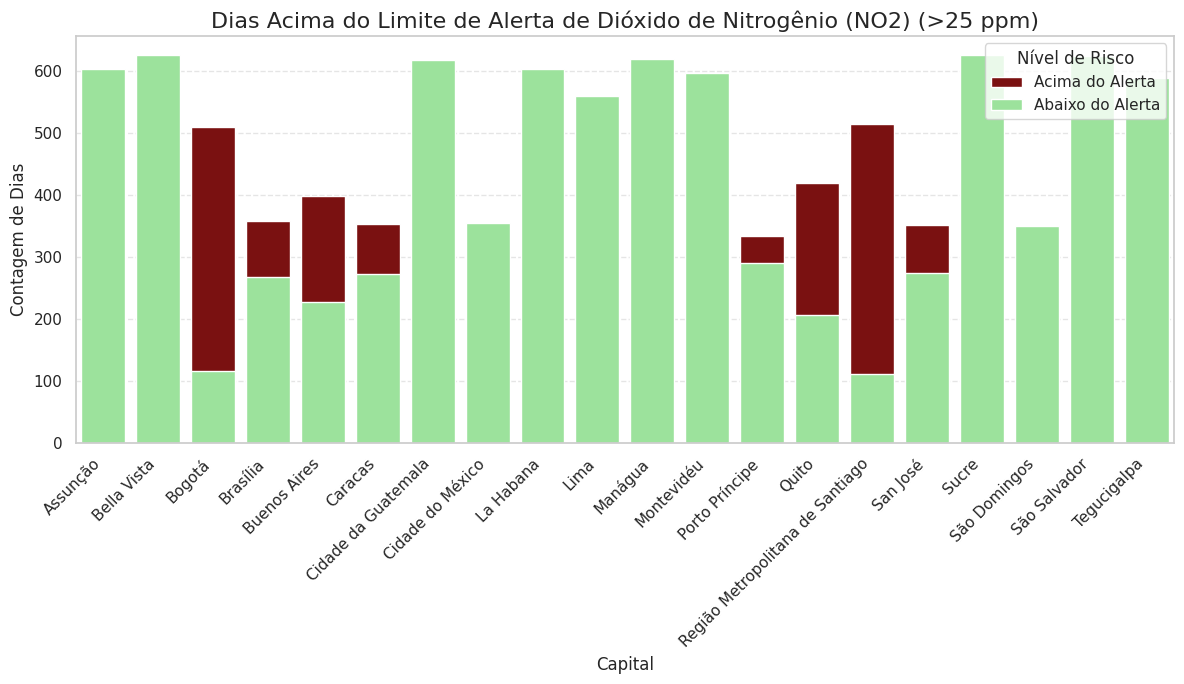

/tmp/ipython-input-2898052291.py:54: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



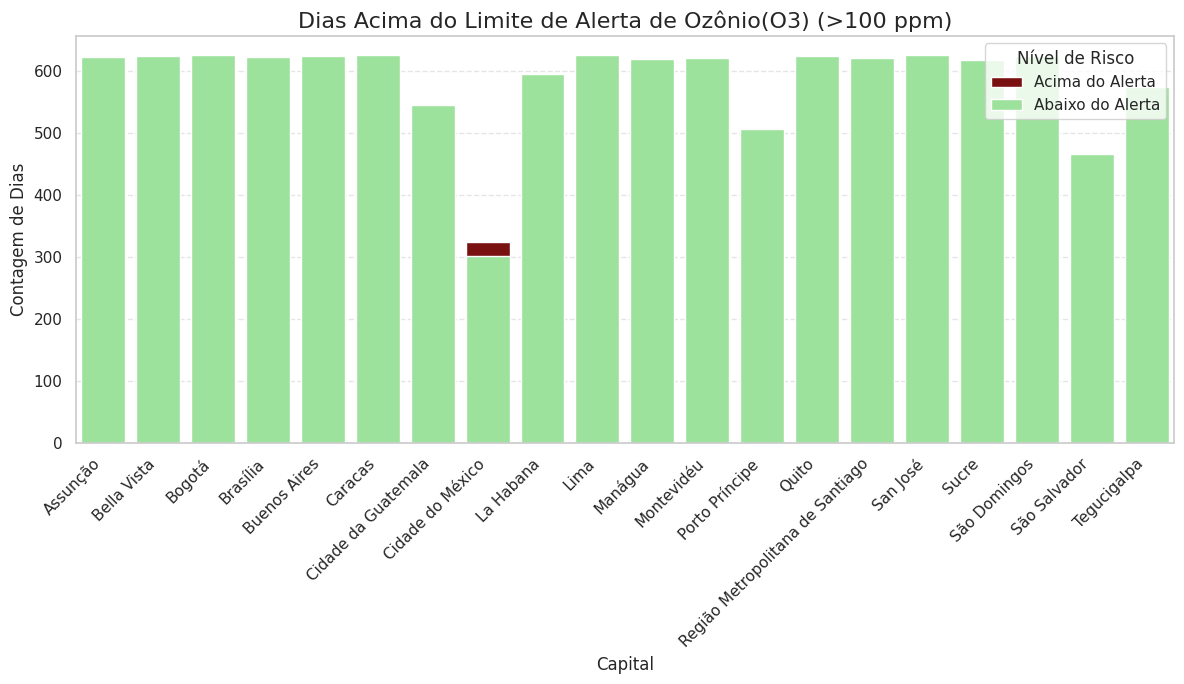

/tmp/ipython-input-2898052291.py:54: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



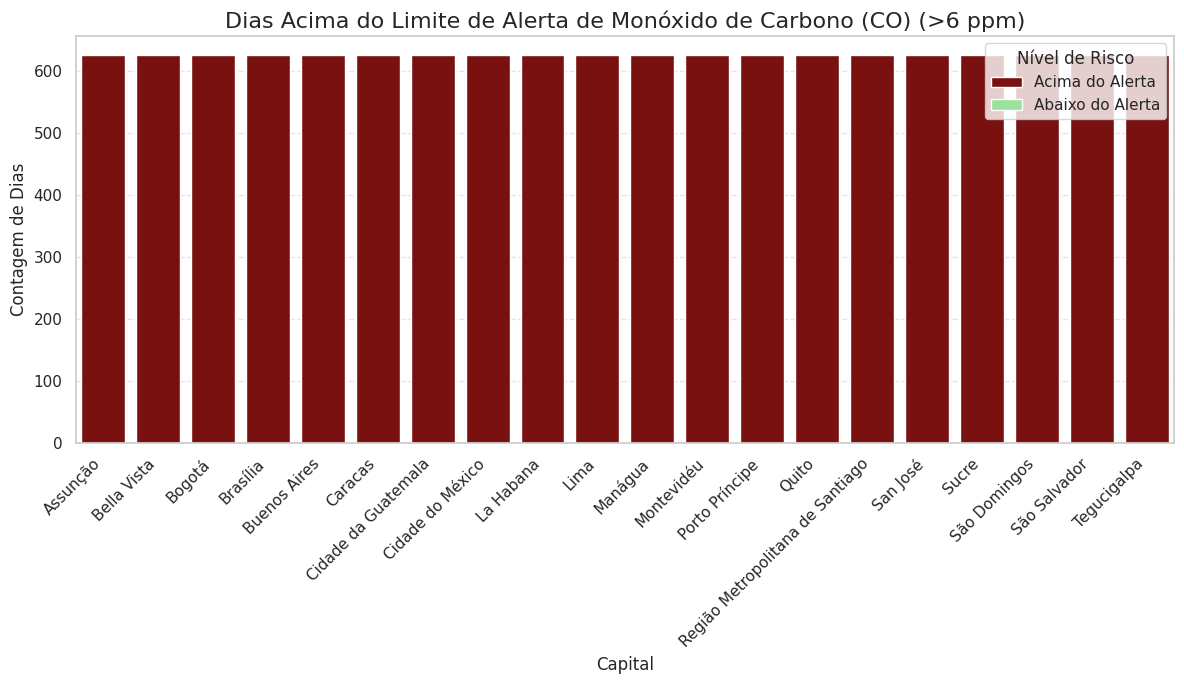

/tmp/ipython-input-2898052291.py:54: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



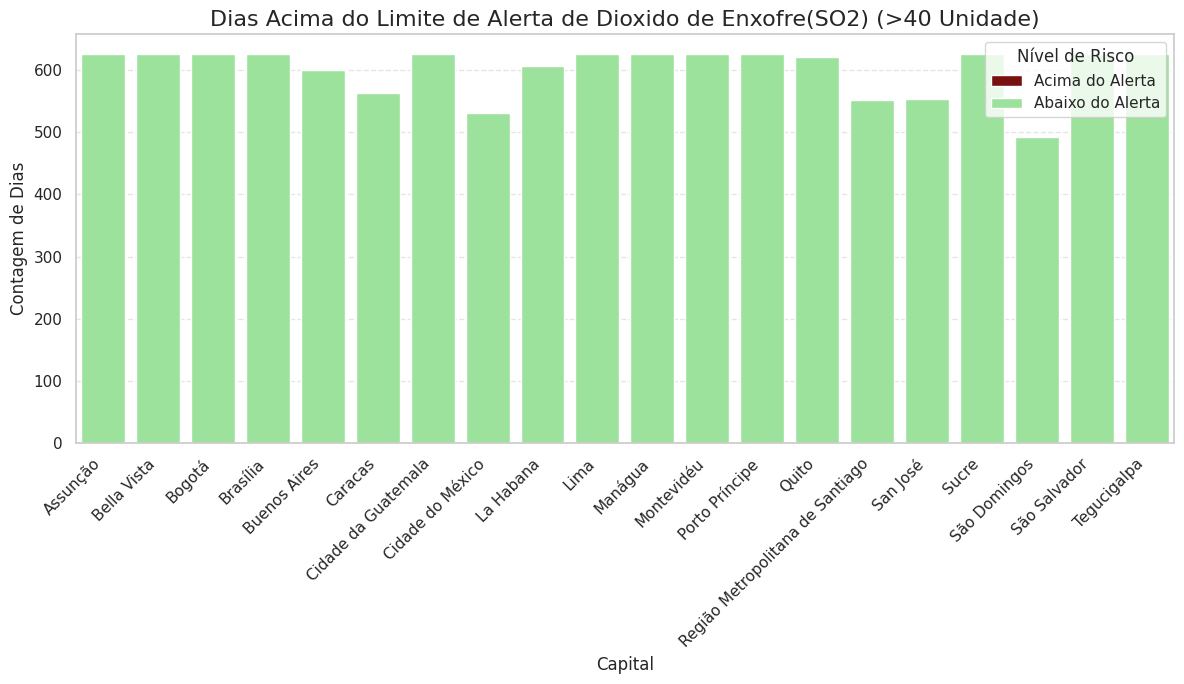

In [14]:
# --- 0. PREPARAÇÃO E DEFINIÇÃO DE LIMITES ---

# 1. Garantir que a coluna 'Data' seja do tipo datetime (manter)
dados_clima['Data'] = pd.to_datetime(dados_clima['Data'], errors='coerce')
df_eventos_base = dados_clima.dropna(subset=['Cidade']).copy()

# 2. DEFINIÇÃO DE LIMITES DE ALERTA (Ajuste estes valores conforme a norma desejada)
# Assumimos limites diários ou de 24h, exceto para CO (que geralmente é 8h)
limites_alerta = {
    'PM10': 45,    # μg/m³
    'PM2_5': 15,   # μg/m³
    'Dióxido de Nitrogênio (NO2)': 25,    # μg/m³
    'Ozônio(O3)': 100,     # μg/m³
    'Monóxido de Carbono (CO)': 6,       # ppm
    'Dioxido de Enxofre(SO2)': 40      # μg/m³
}

# Filtra a lista para incluir SOMENTE as colunas que realmente existem no DataFrame
colunas_disponiveis = df_eventos_base.columns.tolist()
indicadores_poluicao = [ind for ind in limites_alerta.keys() if ind in colunas_disponiveis]

# Dicionário de unidades (para o título)
unidades = {
    'PM10': 'μg/m³',
    'PM2_5': 'μg/m³',
    'Ozônio(O3)': 'ppm',
    'Dióxido de Nitrogênio (NO2)': 'ppm',
    'Monóxido de Carbono (CO)': 'ppm',
    'Dióxido de Enxofre(SO2)':'ppm'
}

print(f"✅ Indicadores a serem analisados: {indicadores_poluicao}")

# --- 3. FUNÇÃO PARA GERAR O GRÁFICO DE BARRAS EMPILHADAS ---

def plot_contagem_de_eventos(df_base, indicador, limite, unidade):

    # Remove NaN para as colunas necessárias para o plot
    df_plot = df_base.dropna(subset=[indicador, 'Cidade']).copy()

    if df_plot.empty:
        print(f"Aviso: Dados insuficientes para plotar {indicador}.")
        return

    # CLASSIFICAÇÃO POR CATEGORIA DE RISCO
    df_plot['Risco'] = pd.cut(
        df_plot[indicador],
        bins=[-float('inf'), limite, float('inf')],
        labels=['Abaixo do Alerta', 'Acima do Alerta'],
        right=False
    )

    # AGRUPAMENTO E CONTAGEM
    df_contagem = df_plot.groupby(['Cidade', 'Risco']).size().reset_index(name='Contagem_Dias')

    # Garantir a ordem das categorias (importante para o empilhamento)
    df_contagem['Risco'] = pd.Categorical(
        df_contagem['Risco'],
        categories=['Abaixo do Alerta', 'Acima do Alerta'],
        ordered=True
    )

    # --- GERAÇÃO DO PLOT ---
    plt.figure(figsize=(12, 7))

    sns.barplot(
        data=df_contagem,
        x='Cidade',
        y='Contagem_Dias',
        hue='Risco',
        hue_order=['Acima do Alerta', 'Abaixo do Alerta'], # O mais crítico primeiro
        dodge=False, # Essencial para empilhar
        palette={'Acima do Alerta': 'darkred', 'Abaixo do Alerta': 'lightgreen'}
    )

    # AJUSTES FINAIS DO LAYOUT
    unidade_str = unidade.get(indicador, 'Unidade')
    titulo = f'Dias Acima do Limite de Alerta de {indicador} (>{limite} {unidade_str})'

    plt.title(titulo, fontsize=16)
    plt.xlabel('Capital', fontsize=12)
    plt.ylabel('Contagem de Dias', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Nível de Risco', loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


# --- 4. EXECUÇÃO DO LOOP PARA TODOS OS INDICADORES ---

for indicador in indicadores_poluicao:
    limite = limites_alerta[indicador]
    plot_contagem_de_eventos(df_eventos_base, indicador, limite, unidades)

**Análise Empírica dos Resultados:**

Dos gráficos analisados, os referentes a três indicadores específicos chamam bastante atenção:

- `Dióxido de Nitrogênio (NO₂)`:

Santiago, no Chile, apresentou **mais de 70% dos dias com concentrações de NO₂ acima do limite da OMS**. Isso se deve à combinação de sua localização em uma bacia cercada pelos Andes, que favorece o acúmulo de poluentes e inversões térmicas, ao tráfego intenso, presença de indústrias e queima de combustíveis fósseis em residências e termelétricas.

Bogotá, na Colômbia, e Quito, no Equador, **apresentam padrões semelhantes**. Ambas estão em altitudes elevadas e vales cercados, o que limita a dispersão do NO₂. O tráfego urbano intenso, o uso de diesel e gasolina, e condições meteorológicas com ventos fracos dificultam a dispersão dos poluentes.

Cidades planas como Buenos Aires e Brasília também registram **altos níveis temporários de NO₂**. Nesses casos, o **tráfego intenso, indústrias e períodos de inverno ou seca** contribuem para o acúmulo do poluente. De forma geral, altitudes elevadas, topografia restritiva, tráfego intenso e condições sazonais desfavoráveis combinam-se para manter altas concentrações de NO₂ nessas capitais latino-americanas.

- `Monóxido de Carbono (CO)`

Todas as capitais latino-americanas apresentaram concentrações de monóxido de carbono (CO) acima dos limites da OMS em todos os dias analisados. Isso se deve principalmente à intensa **atividade veicular**, já que a queima incompleta de combustíveis fósseis em motores a gasolina e diesel é a principal fonte de CO nas áreas urbanas.

Além disso, fatores como **topografia** (vales e regiões cercadas por montanhas) e condições meteorológicas desfavoráveis, como **inversões térmicas e baixa ventilação atmosférica**, dificultam a dispersão do poluente. O uso de combustíveis residenciais e industriais, aliado ao crescimento urbano acelerado, contribui para manter o CO persistentemente acima dos limites em todas as capitais latino-americanas.

- `Material Particulado 2.5 (PM.2.5)`

Porto Príncipe apresentou mais de 90% dos dias com concentrações de PM₂.₅ acima dos limites da OMS, devido à **intensa poluição urbana e industrial**, uso de combustíveis fósseis de baixa qualidade e emissões de poeira de ruas e obras, combinadas com ventilação atmosférica limitada.

Bogotá e Santiago também registraram períodos acima do limite, embora em menor frequência (60% e 40% dos dias, respectivamente). Em Bogotá, o **tráfego intenso, a alta altitude** e a topografia em vale dificultam a dispersão de partículas. Em Santiago, **inversões térmicas e a bacia cercada pelos Andes**, aliadas ao tráfego e à queima de combustíveis residenciais e termelétricos, contribuem para a elevação de PM₂.₅.

Brasília, exemplarmente, não apresenta nenhum dia acima do limiar esabelecido pela OMS.

### **4. Gráficos interativos**

Foram gerados dois gráficos interativos, um para análise das concentrações observadas para os gases e materiais particulados do dataframe dentro da distribuição em violino, além de visualização dos quartis, e um segundo para contemplação, num mapa, da variação temporal do PM.10 nas capitais latino-americanas.
Uma vez que o processamento destes gráficos consomem tempo e processamento, estão num notebook separado, [Gráficos Interativos](https://github.com/marcelohpos/PROJETO-ICD/blob/master/notebooks/Graficos_interativos.ipynb).